In [1]:
import pandas as pd
import pymysql.cursors
import numpy as np
import matplotlib.pyplot as plt
import pytube
import subprocess
import cv2
import os
import numpy as np
import time
from scipy.stats import norm
import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
import joblib
with open("TestVideo_set_v2.pkl","rb") as fr:
    TestVideo_set = joblib.load(fr)
    
with open("TestLabel_v2.pkl","rb") as fr:
    TestLabel = joblib.load(fr)

In [3]:
ActivityName=['base','foundation','eyebrow','blusher','eye','shading','lip','skincare','highlighter']
ActivityReName=['skincare','base','foundation','eyebrow','blusher','eye','shading','highlighter','lip']

In [ ]:
unique_video = 0
mov = 30
thres_list = [0.45,0.45,0.55,0.55,0.7,0.6,0.7,0.45,0.7]
case1_list = []
case2_list = []
case3_list = []
case4_list = []
for k in [0,50,100,150]:
    Validation=[]
    for i in range(0+k,50+k):
        if(i==195):
            break
        Test=TestLabel[i]
        mark=max(Test.starttime)/1000*5
        zero_data = np.zeros(shape=(int(mark)+1,len(ActivityName)))
        Val_temp=pd.DataFrame(zero_data,columns=[2,  3,  4,  5,  6,  7,  9,  1,  8])

        for j in range(0,len(Test)):
            #print (j)
            STidx=Test[j:j+1].starttime.values/1000*5
            if Test[j:j+1].makeuppart_id.values == 10:
                continue
            Val_temp.loc[int(STidx),Test[j:j+1].makeuppart_id]=1
        Val_temp.columns=ActivityName
        Val_temp=Val_temp[ActivityReName]
        Validation.append(Val_temp)

    timestep=5
    x_test=[]
    for i in range(0+k,50+k):
        if(i == 195):
            break
        temp=TestVideo_set[i]
        x_temp=[]
        for j in range(0,len(temp)-timestep):
            x_temp.append(temp[j:j+timestep])
        x_temp=np.asarray(x_temp)
        x_test.append(x_temp)

    LoadModel=load_model('5FPS_5TS_CNN_LSTM_Model_9C_v2.h5')
    result1=[]
    for i in range(0,len(x_test)):
        result_temp1=LoadModel.predict(x_test[i])
        result_temp1=pd.DataFrame(result_temp1, columns=ActivityName)
        result_temp1=result_temp1[ActivityReName]
        result1.append(result_temp1)
    for vid_num in range(0,len(Validation)):
        print(unique_video)
        try:
            df = pd.DataFrame(result1[vid_num])
            df = df.rolling(mov).mean().dropna()
            for th in range(len(thres_list)):
                df.iloc[:,th] = df.iloc[:,th].apply(lambda x: x>=thres_list[th]).replace([True, False],[1,0])
            max_val = df.index.max()
            idx_list = df[df.sum(axis = 1) == 1].index
            df = df[df.sum(axis = 1) == 1].reset_index()
            idx_tmp = [i for i in range(idx_list[0],idx_list[-1]+1)]
            df_tmp = pd.DataFrame(idx_tmp)
            df_tmp.columns = ['index']
            df_tmp.loc[len(df_tmp),'index'] = max_val
            df = pd.merge(df_tmp,df,how = 'left').fillna(0)
            idx_list = list(df[df.iloc[:,1:].sum(axis = 1) == 1].index);idx_list.append(max_val)

            for i in range(len(idx_list)-1):
                df.iloc[idx_list[i]:idx_list[i+1],1:] = df.iloc[idx_list[i]:idx_list[i+1],1:].cumsum()

            df_vid = Validation[vid_num].apply(lambda x: x>=0.5).replace([True, False],[1,0]).reset_index()

            df_vid = df_vid.replace([0,1],[np.nan,1])
            df = df.replace([0],[np.nan])

            df_vid_idx = list(df_vid[df_vid.fillna(0).iloc[:,1:].sum(axis = 1) > 0].index)
            df_vid_tmp = df_vid[df_vid.index.isin(df_vid_idx)]

            df_idx = list(df[df.fillna(0).iloc[:,1:].sum(axis = 1) > 0].index)
            df_tmp2 = df[df.index.isin(df_idx)]
            part_num = 0
            for part in ActivityReName:
                if(len(df_vid_tmp[df_vid_tmp[part]>0]) == 0):
                    part_num = part_num+1
                    continue
                min_range = int(df_vid_tmp[df_vid_tmp[part]>0]['index'].values[0]-25)
                max_range = int(df_vid_tmp[df_vid_tmp[part]>0]['index'].values[0]+25)
                part_list = [i for i in range(min_range,max_range+1)]
                value1 = int(len(df_tmp2[(df_tmp2[part]>0)&(df_tmp2['index'].isin(part_list))])>0)
                if(value1 == 1):
                    case1_list.append([unique_video, df_vid_tmp[df_vid_tmp[part]>0]['index'].values[0]])
                else:
                    case3_list.append([unique_video, df_vid_tmp[df_vid_tmp[part]>0]['index'].values[0]])
                part_num = part_num+1

            part_num = 0
            for part in ActivityReName:
                try:
                    find_start = df[df[part] == 1][['index',part]].copy(deep = True)
                    find_start['Diff'] = find_start['index'].diff()
                    start_list = list(find_start[find_start.Diff > 1]['index'].values)
                    start_list.append(find_start['index'].to_list()[0])
                    start_list = sorted(start_list)

                    vid_val = df_vid[df_vid[part] == 1]['index'].values[0]
                    for val in range(len(start_list)):
                        next_idx = 0
                        try: 
                            next_idx = start_list[val+1] 
                        except: 
                            next_idx =np.inf
                        list1 = list(find_start[(find_start['index']>=start_list[val])&(find_start['Diff'] == 1)&
                                                (find_start['index']<next_idx)]['index'])
                        min_val =int(vid_val-25)
                        max_val =int(vid_val+25)
                        vid_list = [i for i in range(min_val, max_val+1)]
                        if ((len(set(vid_list).intersection(list1))<=1)):
                            case2_list.append([unique_video,list1[0]])
                        else:
                            continue
                        part_num = part_num+1
                except:
                    part_num = part_num+1
                    continue
            unique_video = unique_video+1
        except:
            case4_list.append(unique_video)
            unique_video = unique_video+1
            continue
    del result_temp1, Validation, x_test, result1    

In [ ]:
sum_val = len(case1_list)+len(case2_list)+len(case3_list)+len(case4_list)

In [ ]:
list2 = [(len(case1_list)/sum_val)*100,(len(case2_list)/sum_val)*100,(len(case3_list)/sum_val)*100,(len(case4_list)/sum_val)*100]

In [ ]:
plt.bar(['Case1','Case2','Case3','Case4'],list2)
plt.yticks(fontsize = 13);plt.xticks(fontsize = 13)
plt.text('Case1',list2[0],str(round(list2[0],1)), fontsize = 13,ha='center', c = 'r')
plt.text('Case2',list2[1],str(round(list2[1],1)), fontsize = 13,ha='center', c = 'r')
plt.text('Case3',list2[2],str(round(list2[2],1)), fontsize = 13,ha='center', c = 'r')
plt.text('Case4',list2[3],str(round(list2[3],1)), fontsize = 13,ha='center', c = 'r')
plt.ylim(0,100)
plt.show()

In [ ]:
c1 = pd.DataFrame(case1_list)
c1.columns = ['vid_num','index']

c2 = pd.DataFrame(case2_list)
c2.columns = ['vid_num','index']

c3 = pd.DataFrame(case3_list)
c3.columns = ['vid_num','index']

c4 =pd.DataFrame(case4_list)
c4.columns = ['vid_num']

In [ ]:
c1.to_excel('c1.xlsx', index = False);c2.to_excel('c2.xlsx', index = False);c3.to_excel('c3.xlsx', index = False);c4.to_excel('c4.xlsx', index = False)

visualize

0


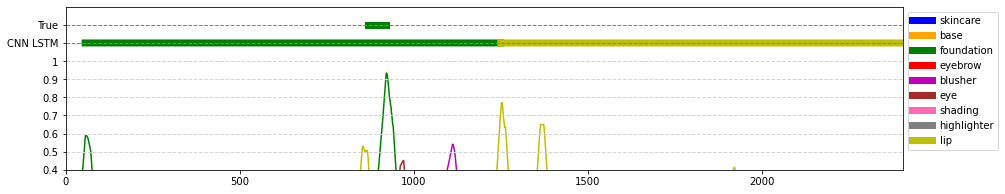

1


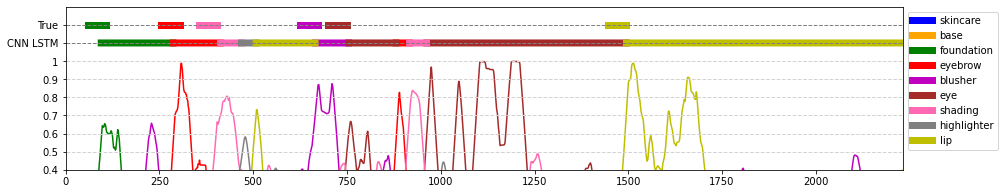

2


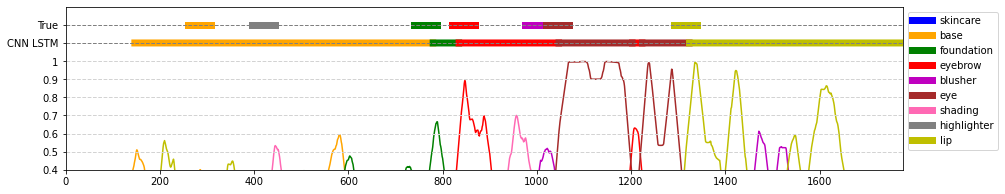

3


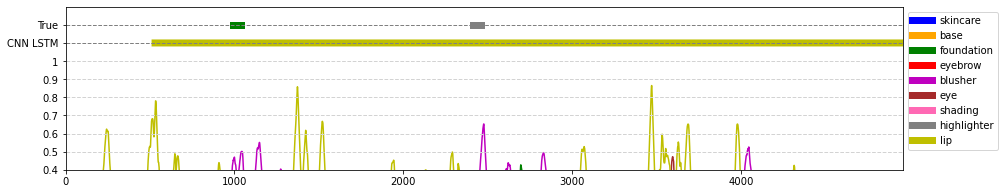

4


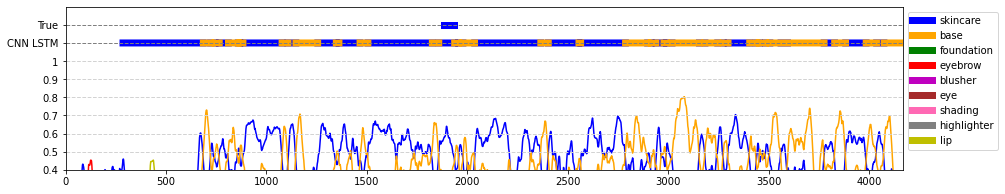

5


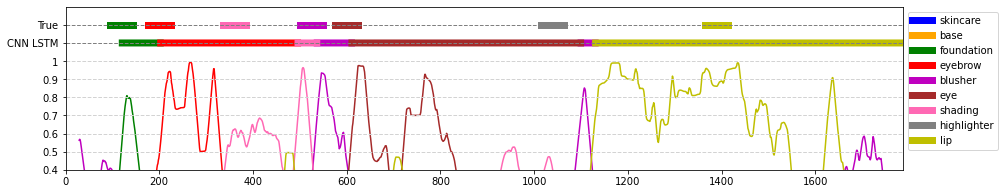

6


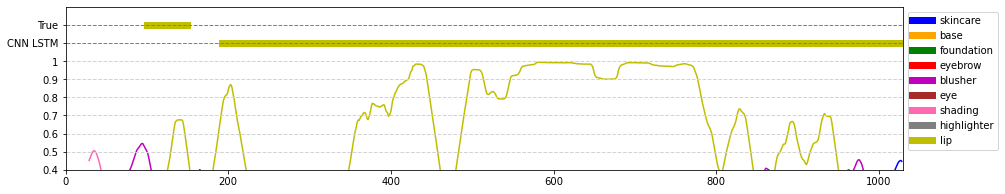

7


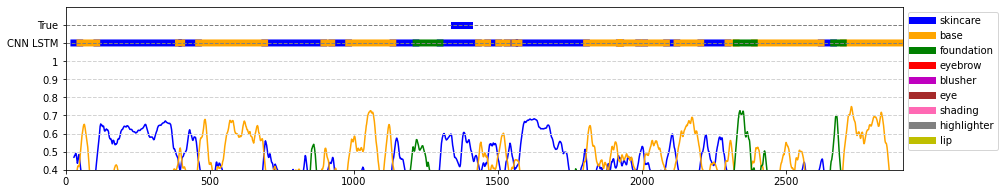

8


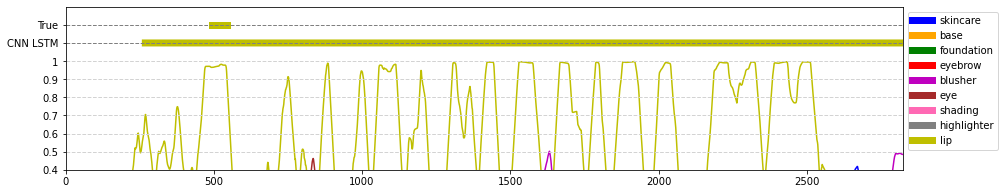

9


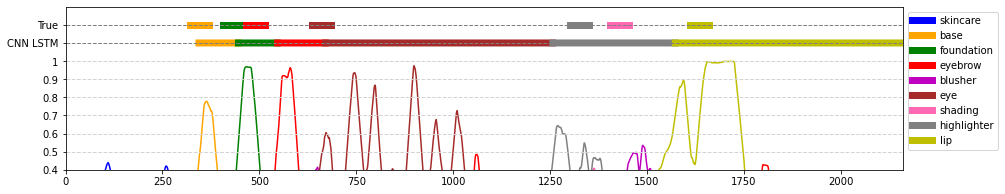

10


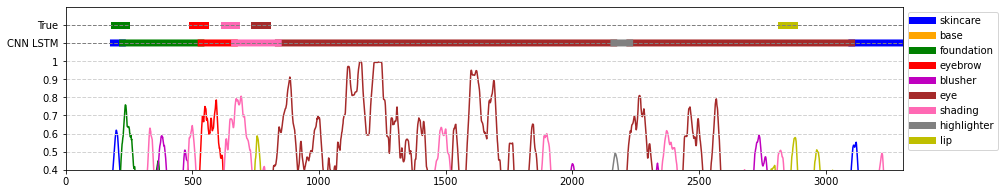

11


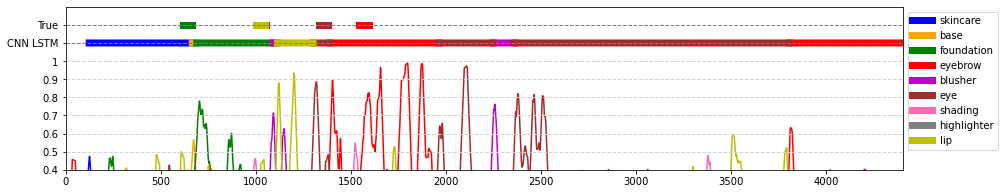

12


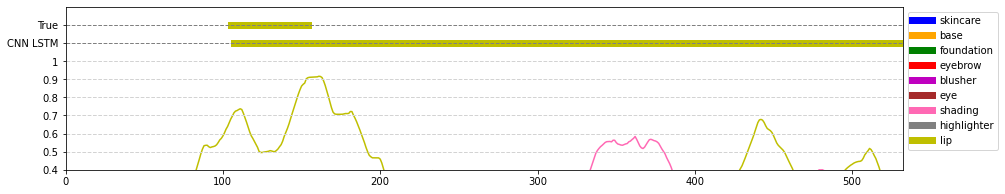

13
14


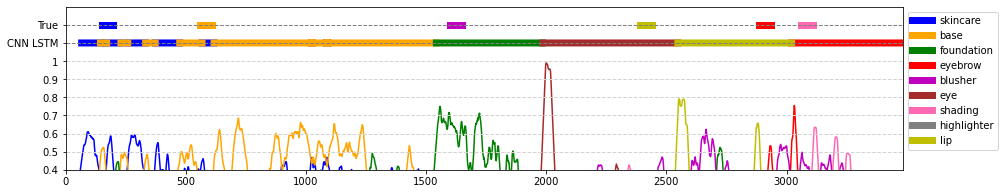

15


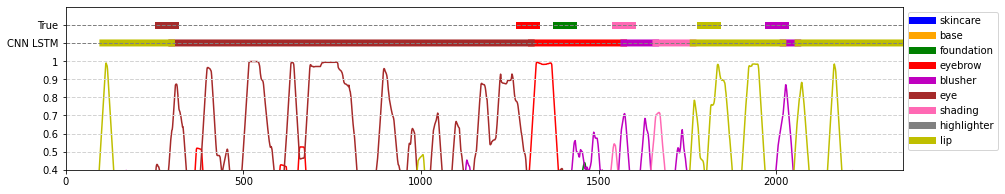

16


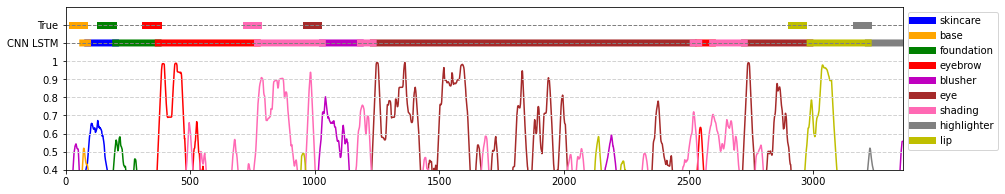

17


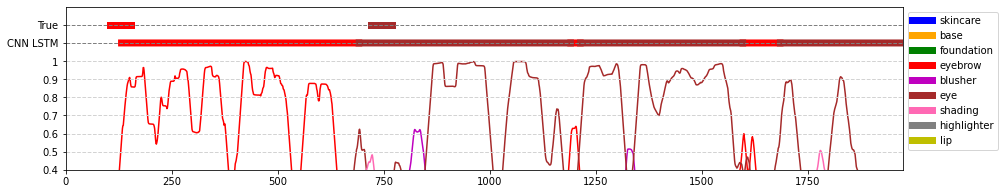

18


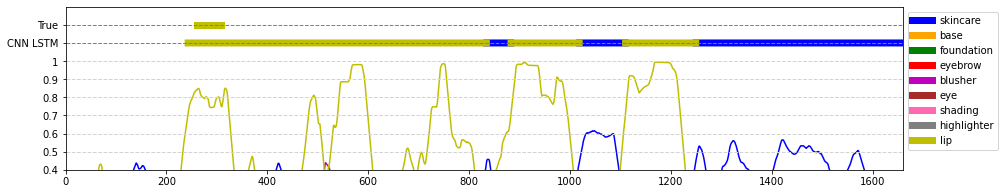

19


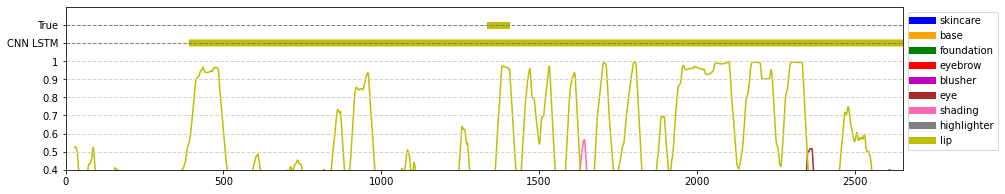

20


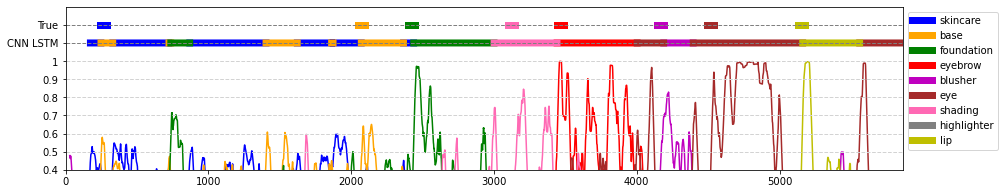

21


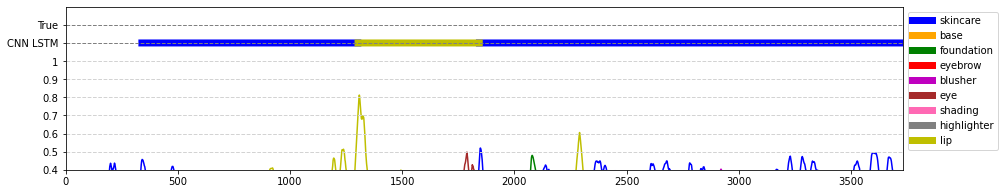

22


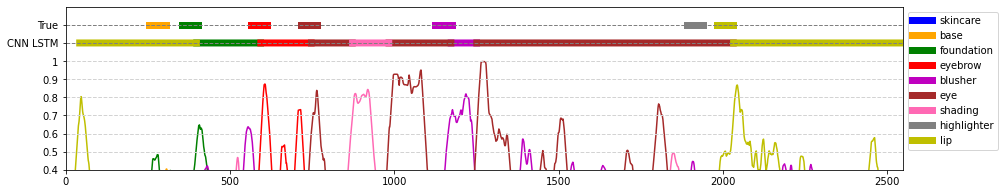

23


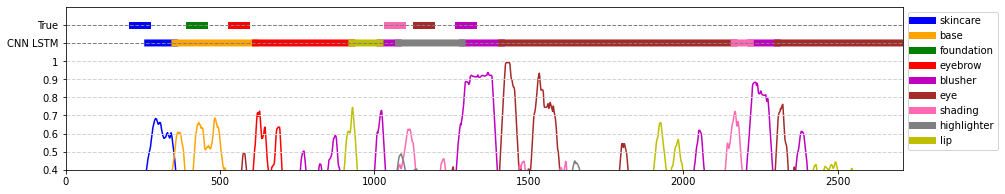

24


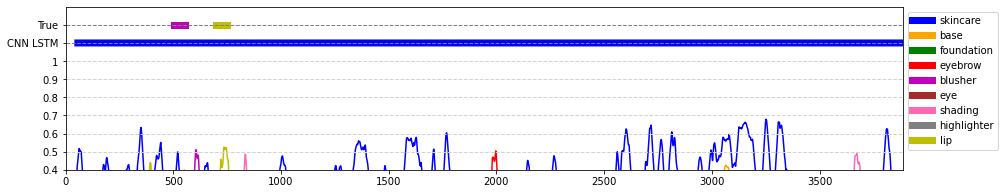

25


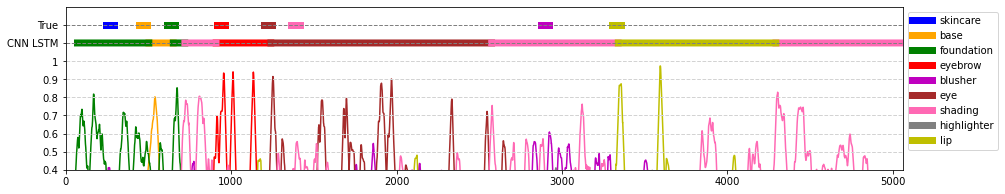

26


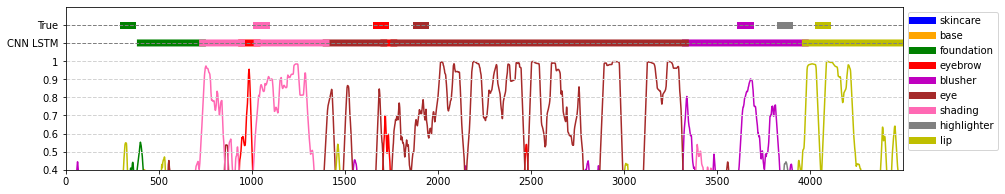

27


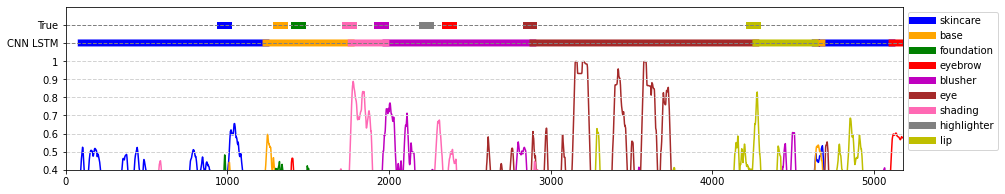

28


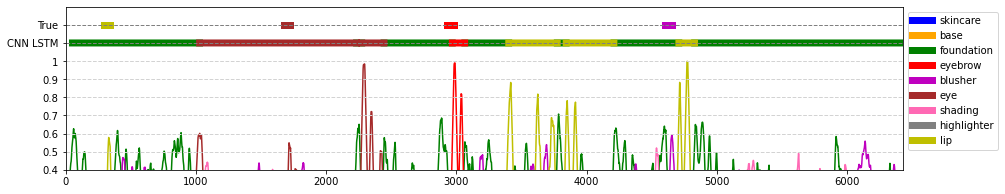

29


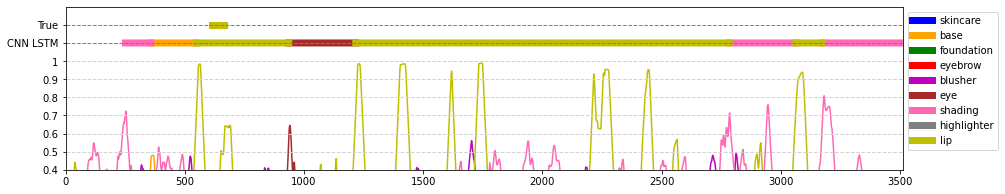

30


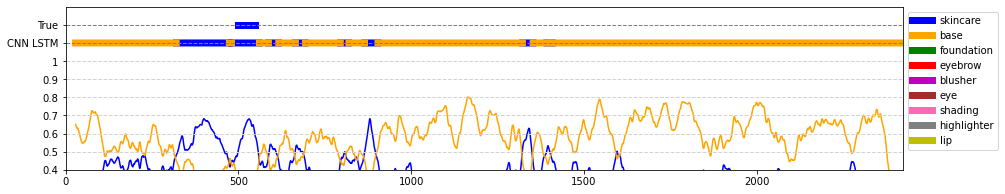

31


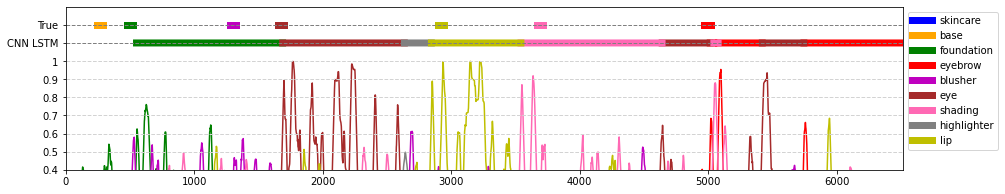

32


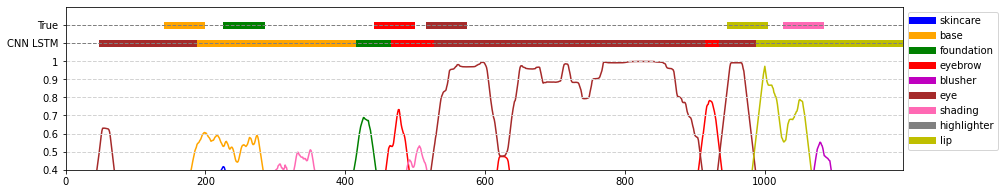

33


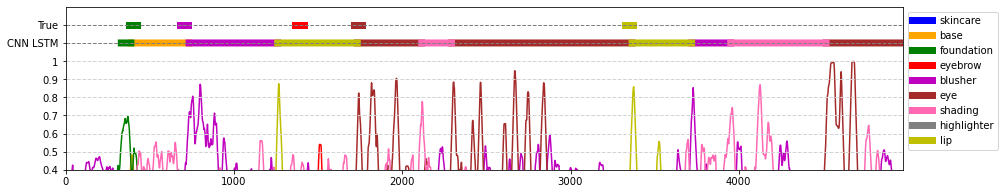

34


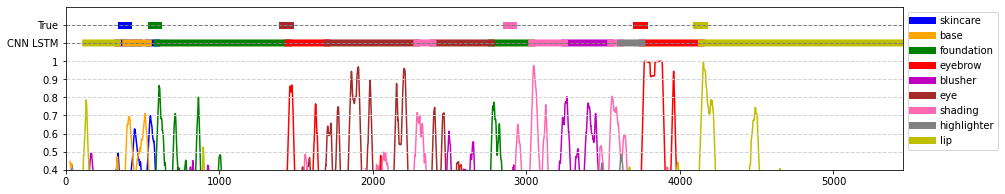

35


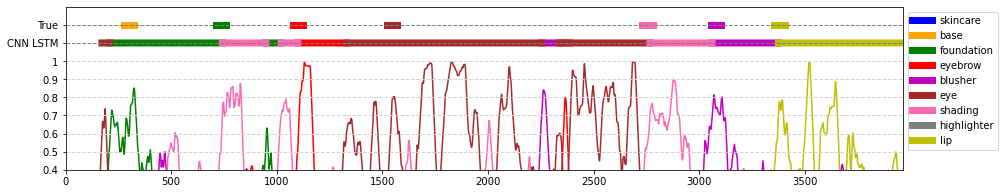

36


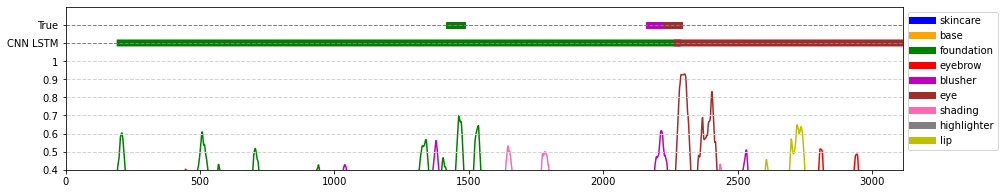

37


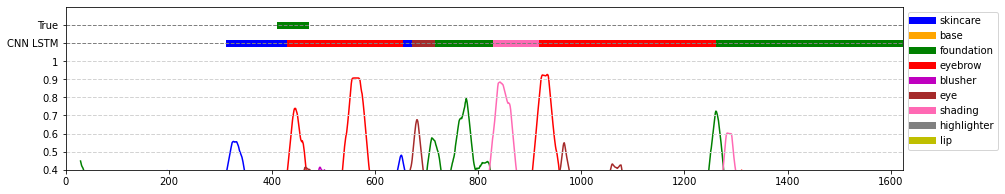

38


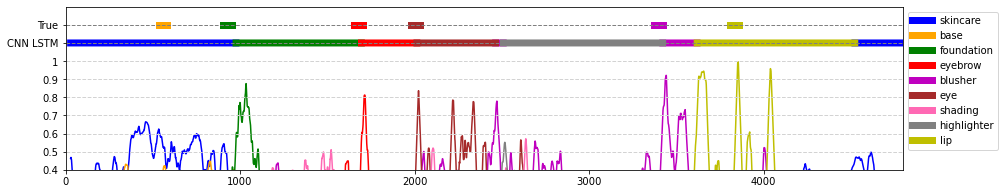

39


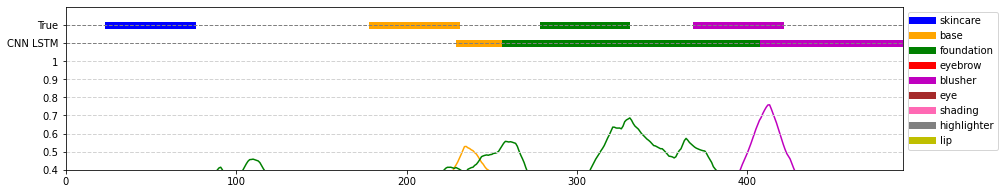

40


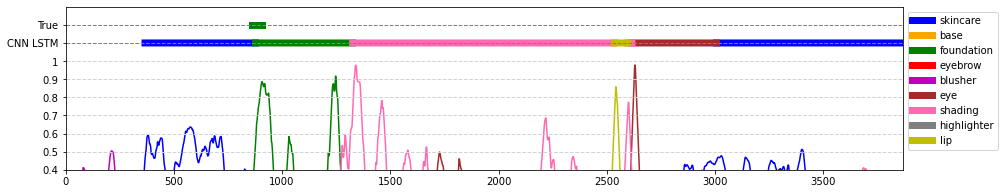

41


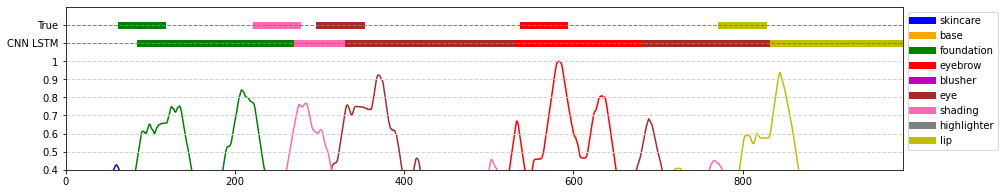

42


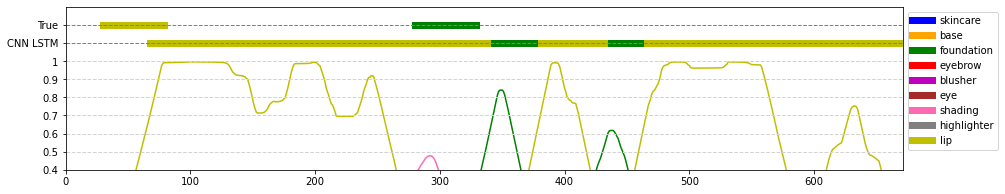

43


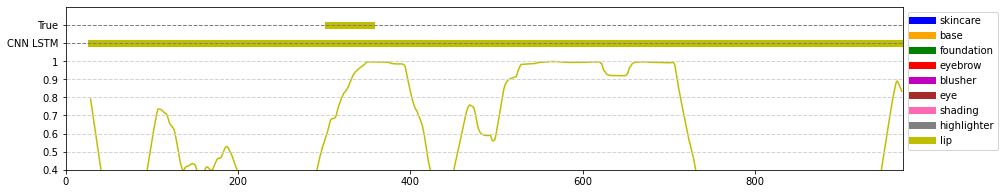

44


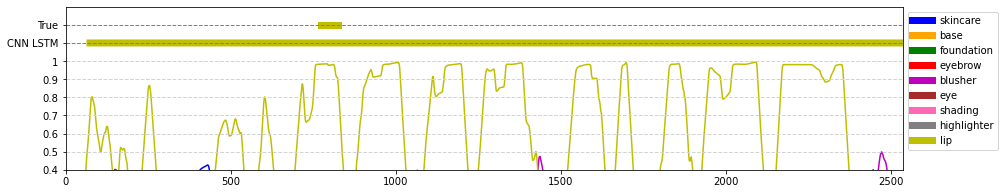

45


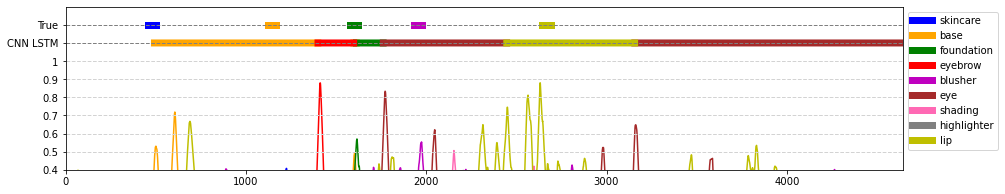

46


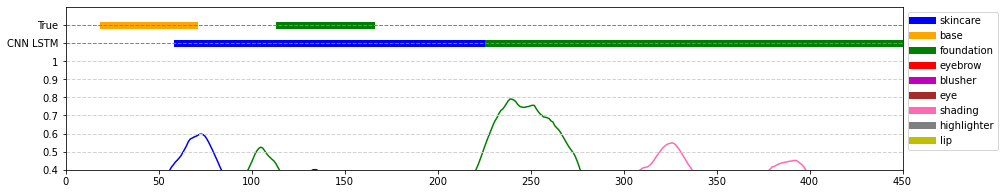

47


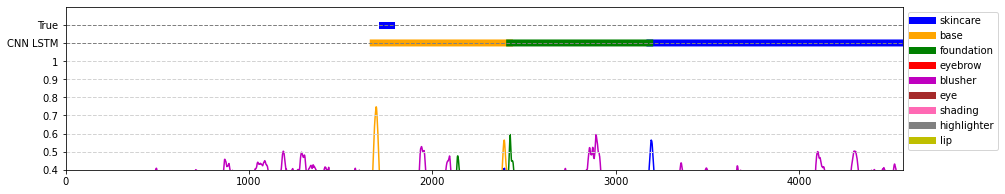

48


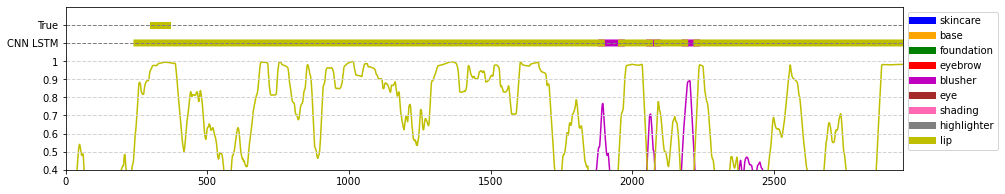

49


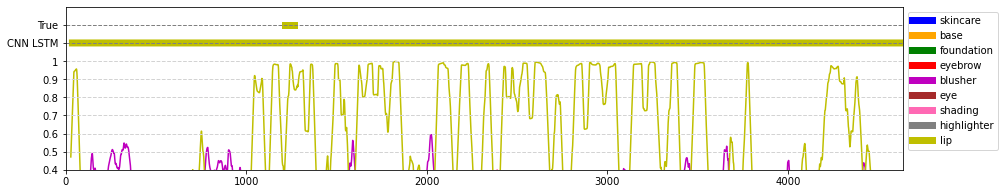

50


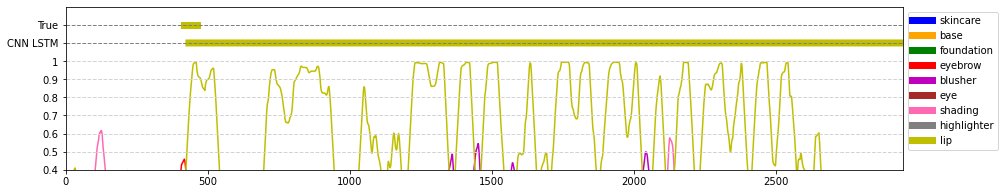

51


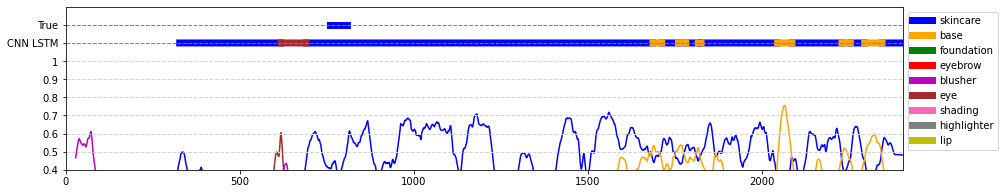

52


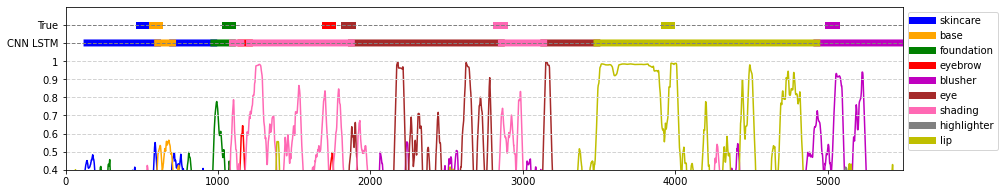

53


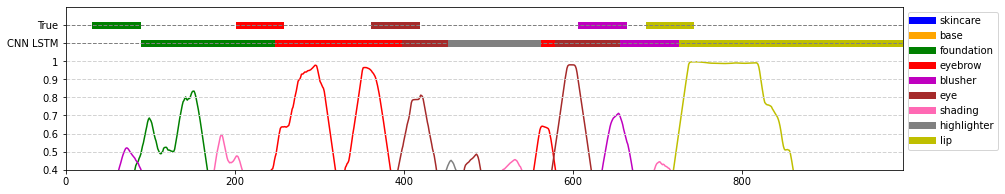

54


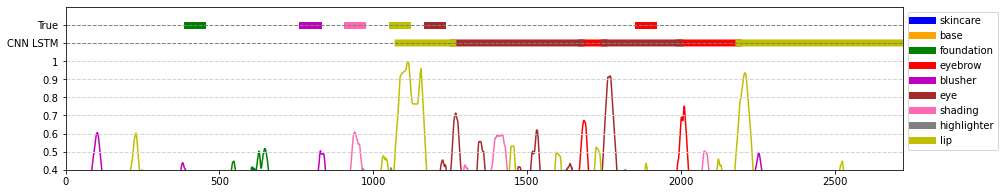

55


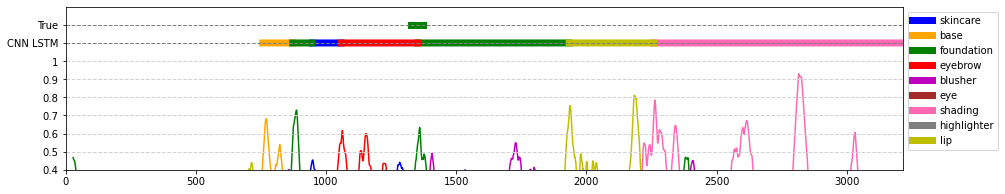

56


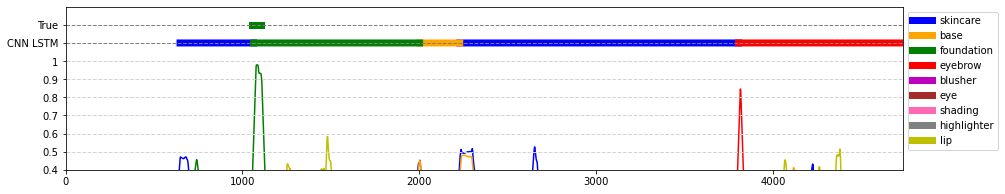

57


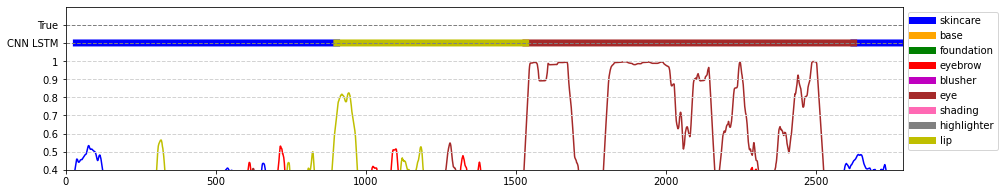

58


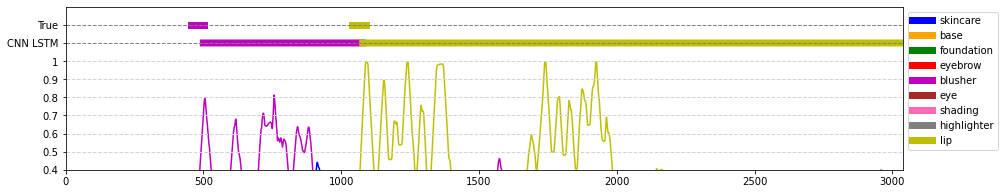

59


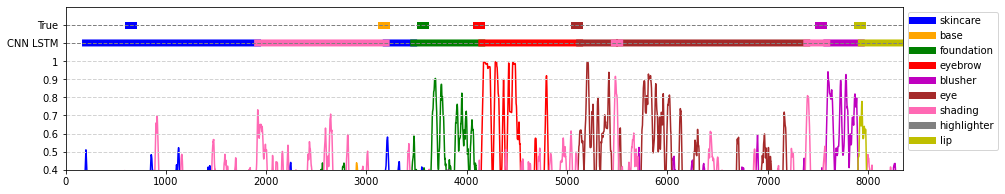

60


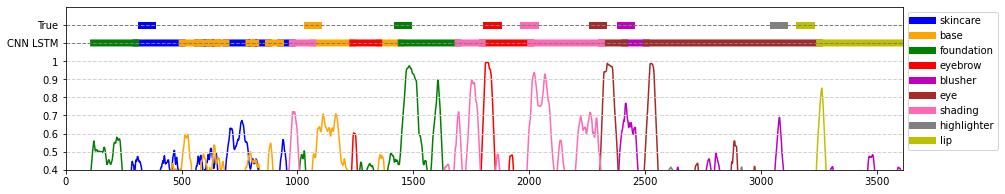

61


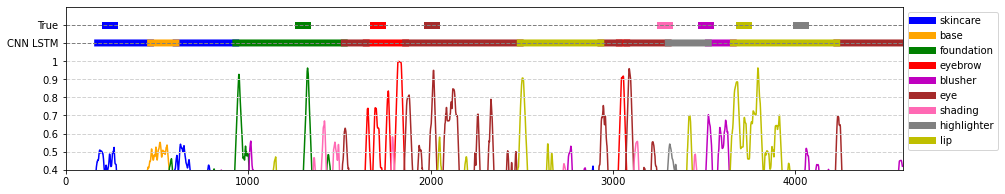

62


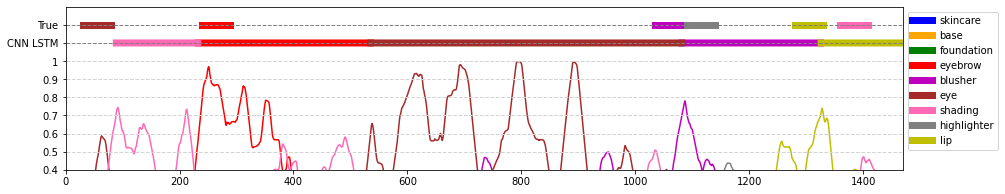

63


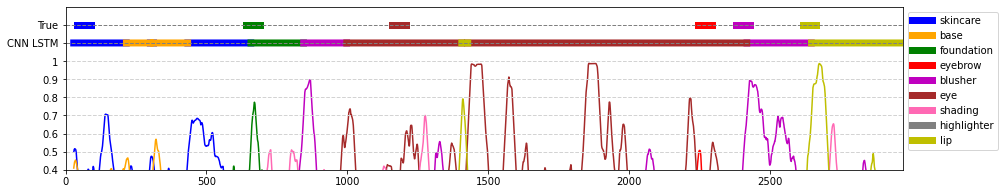

64


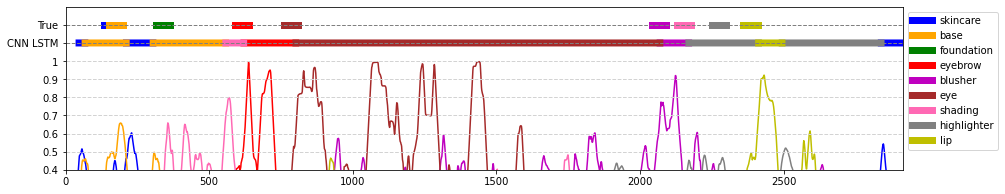

65


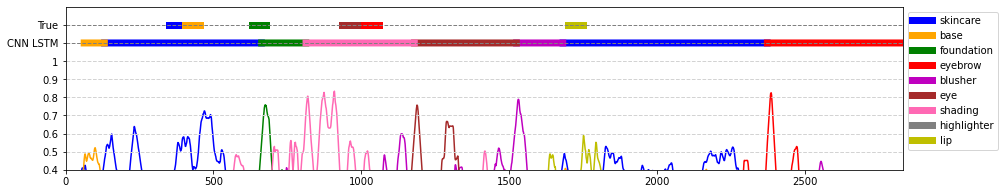

66


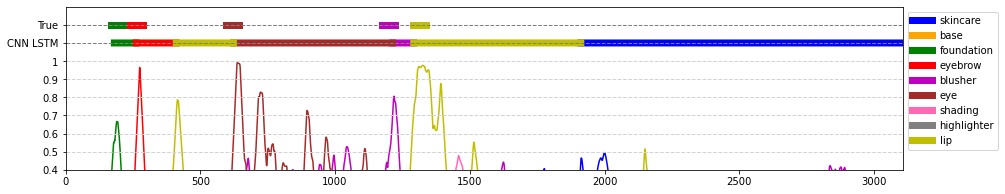

67


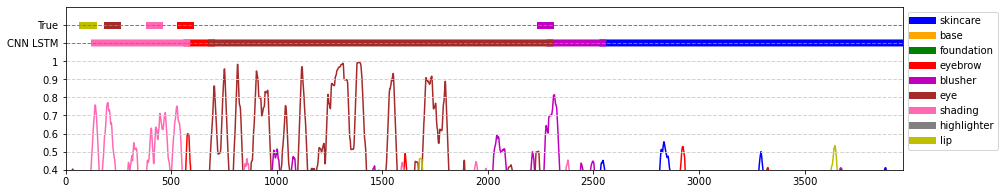

68


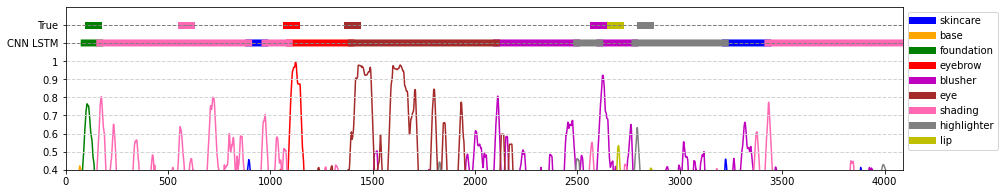

69


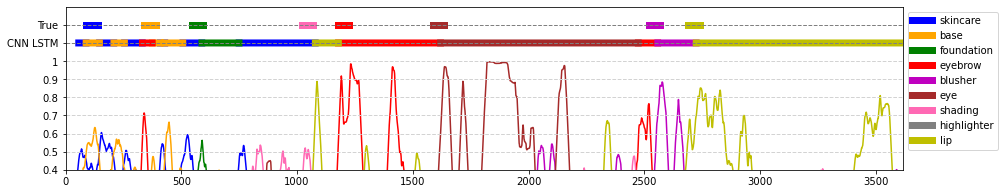

70


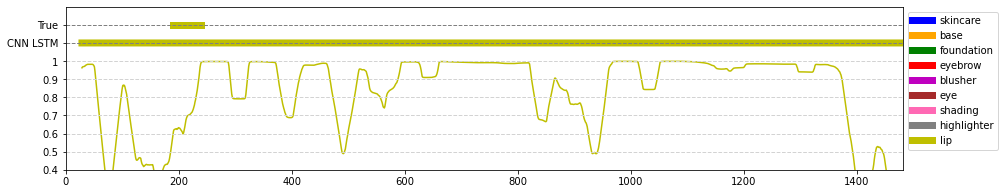

71


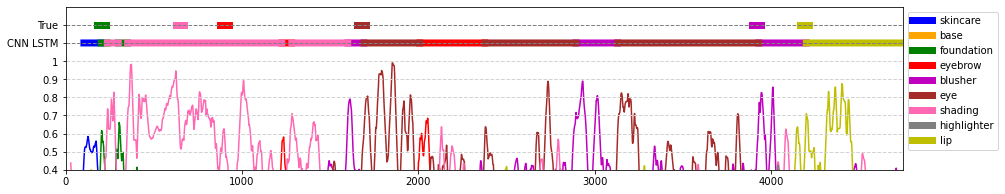

72


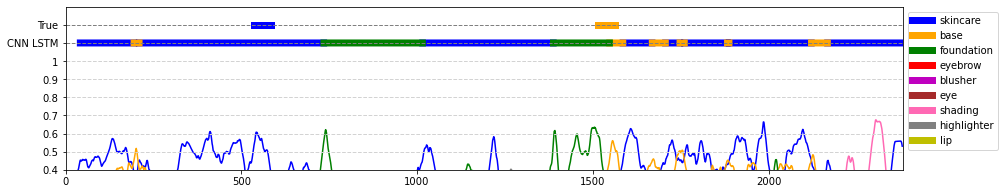

73


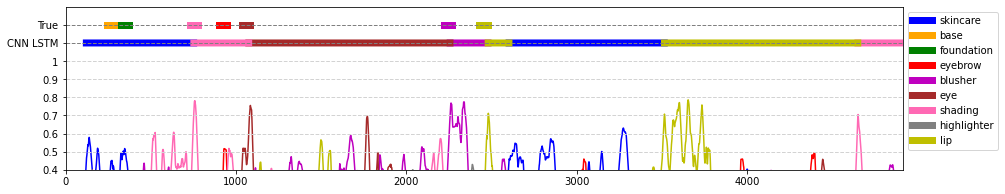

74


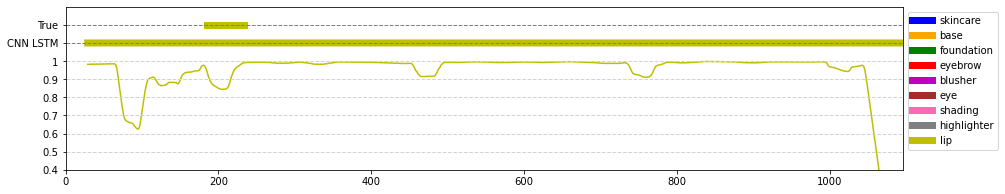

75


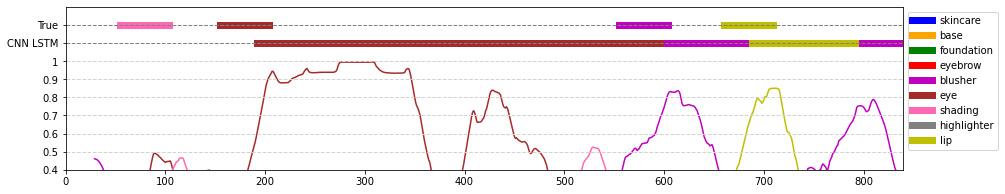

76


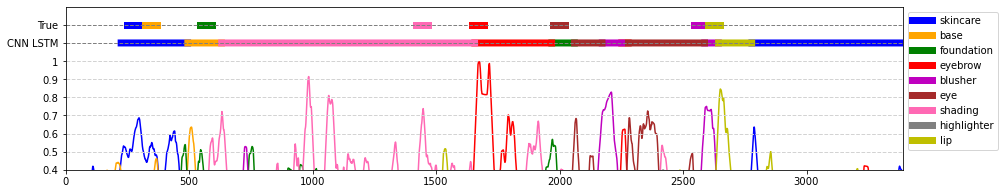

77


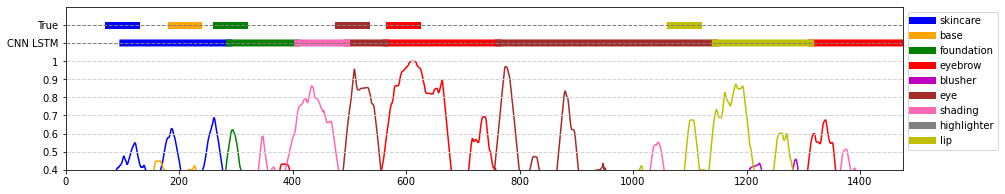

78


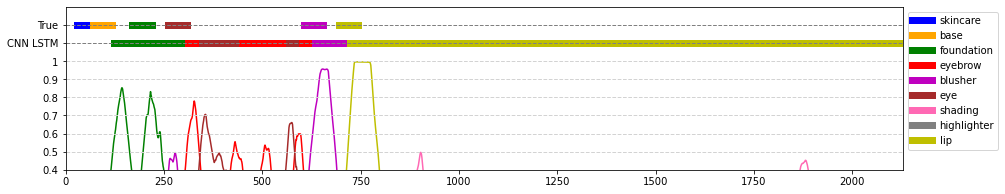

79


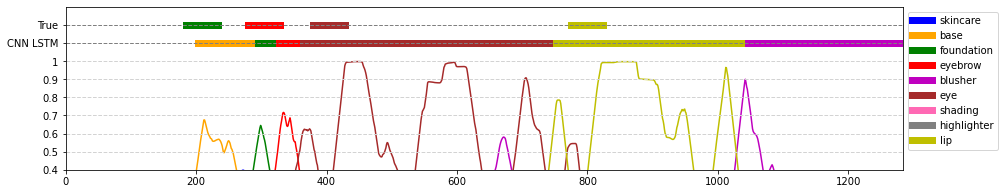

80


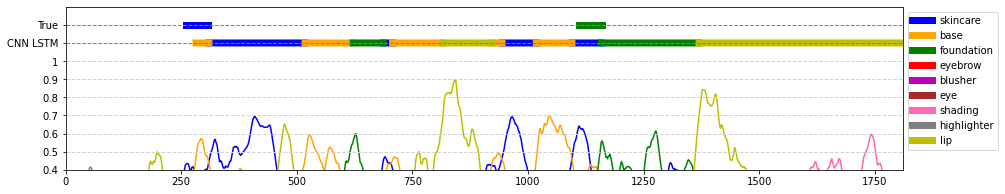

81


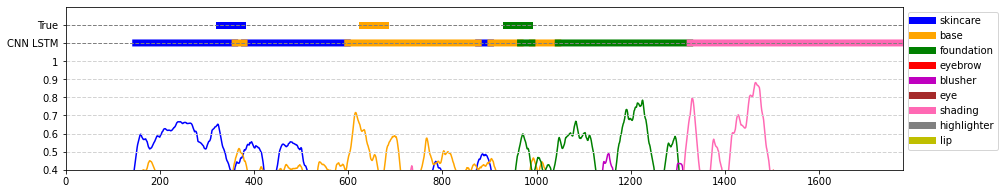

82


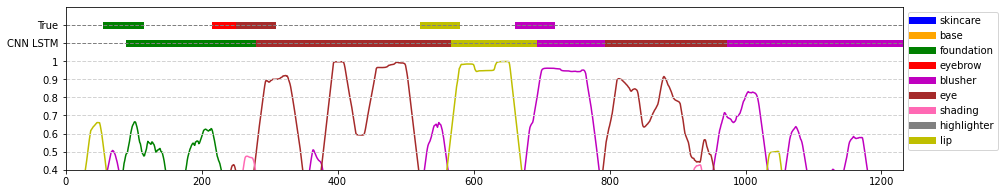

83


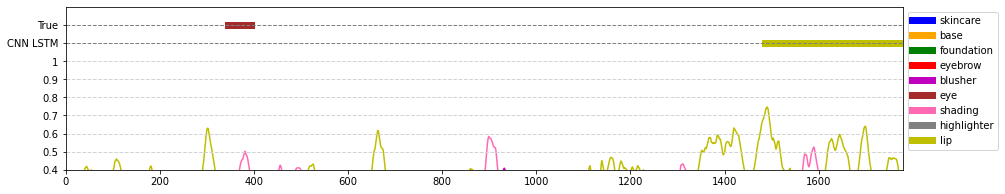

84


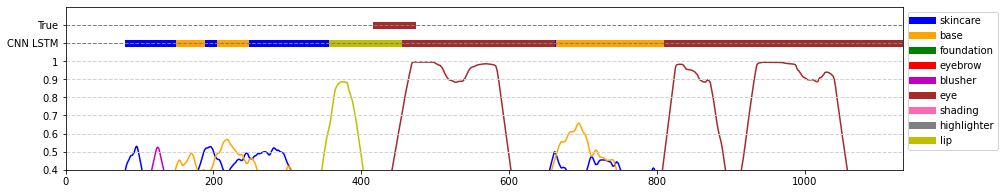

85


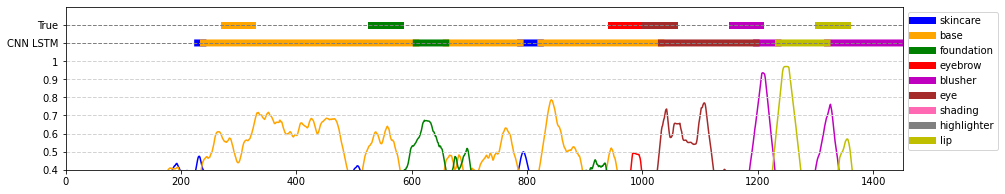

86


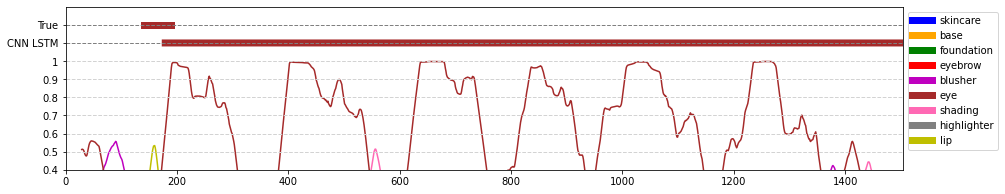

87


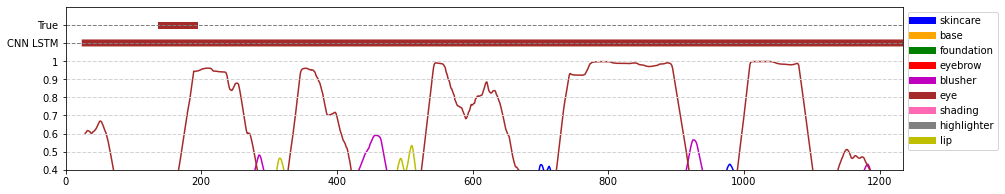

88


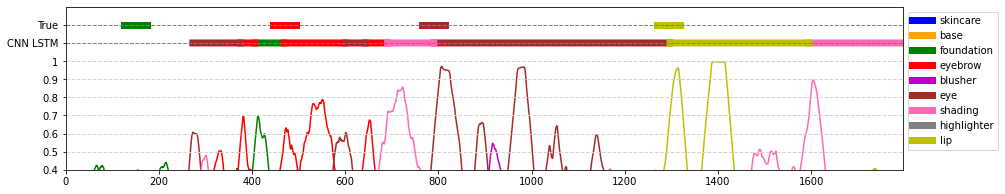

89


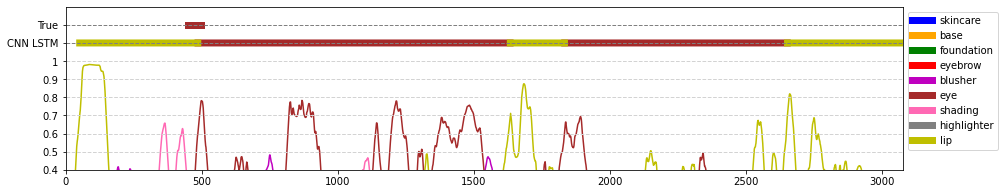

90


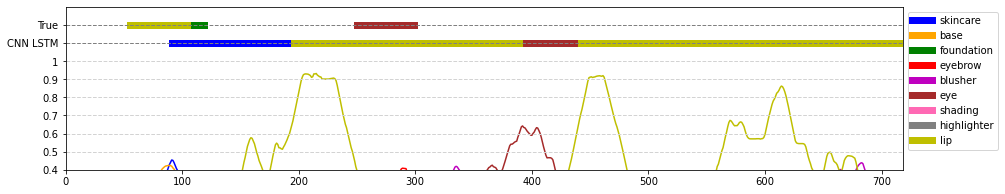

91


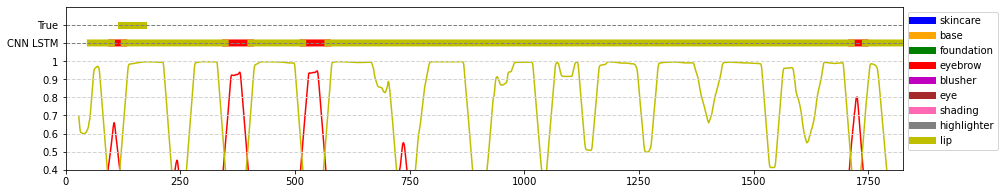

92


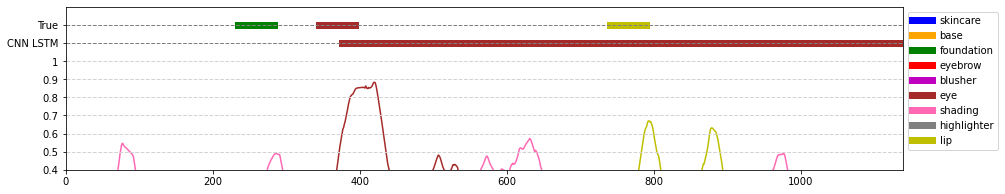

93


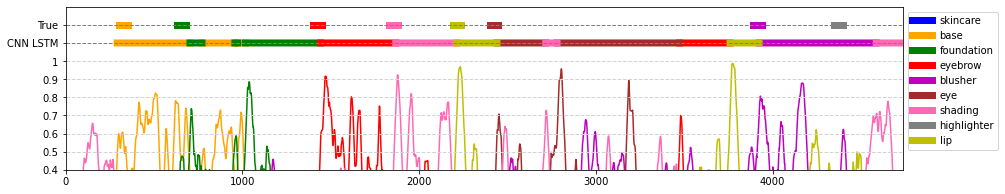

94


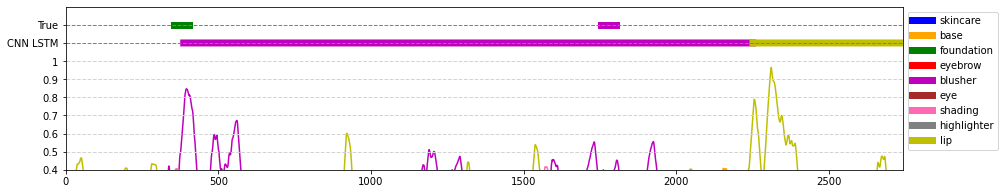

95


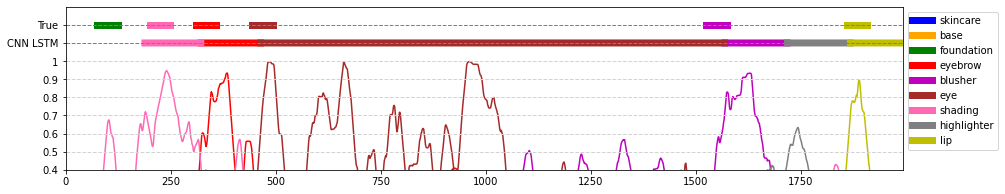

96


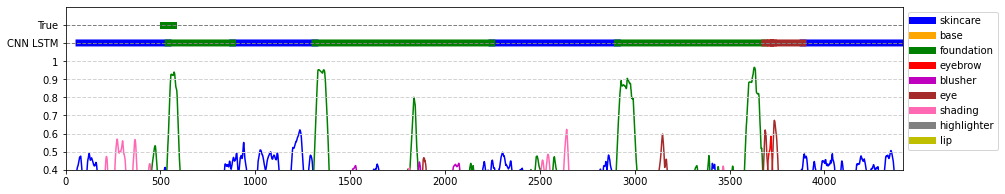

97


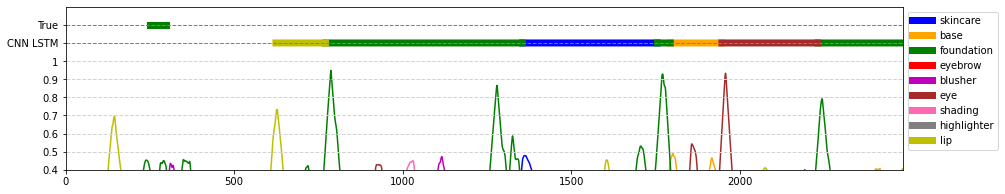

98


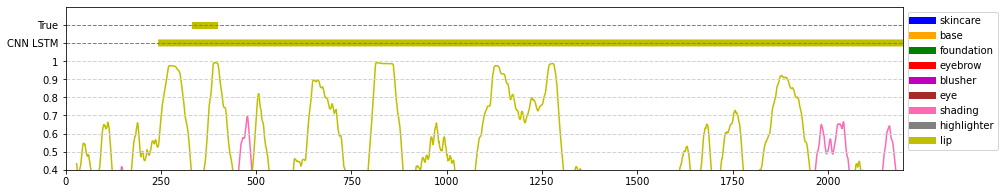

99


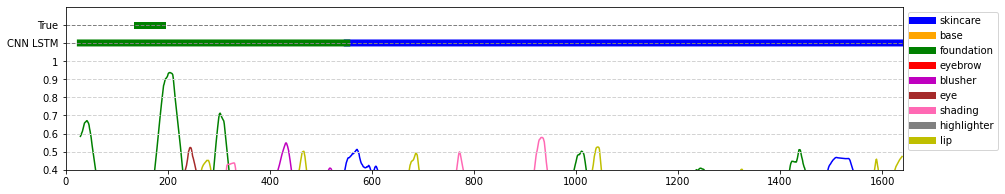

100


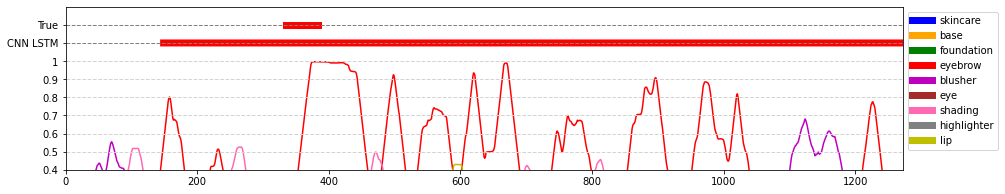

101


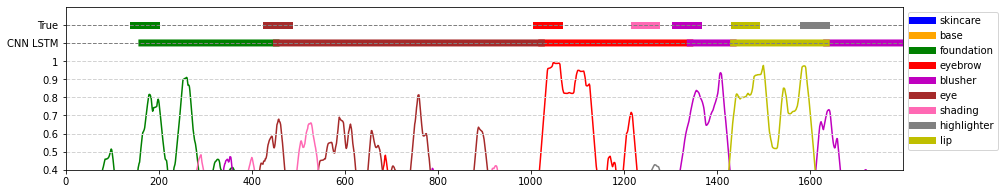

102


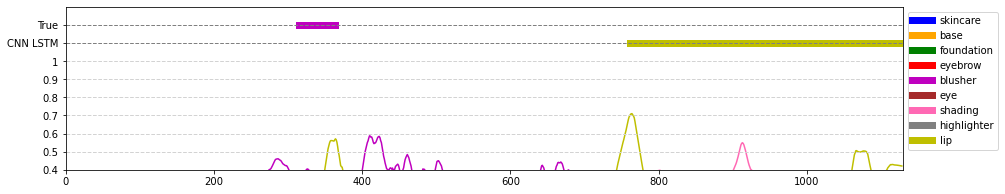

103


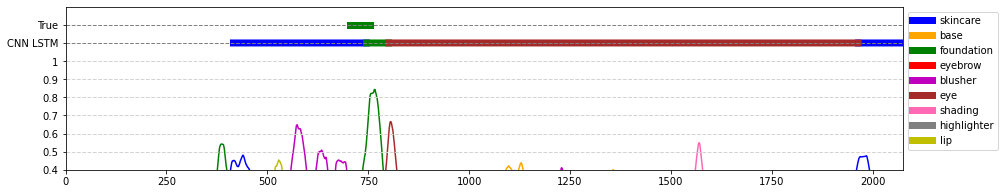

104


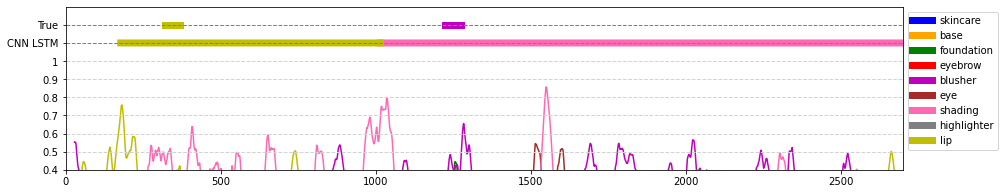

105


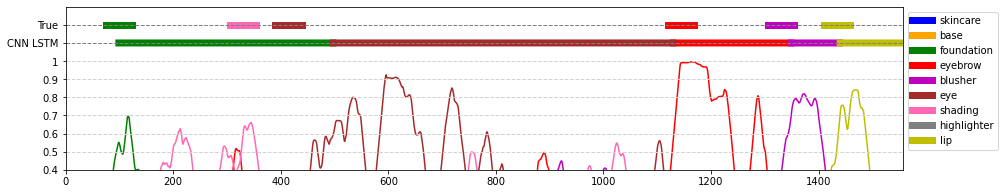

106


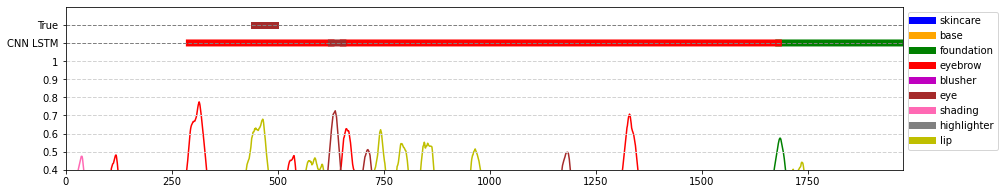

107


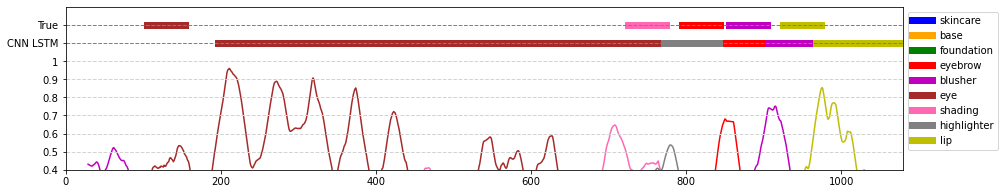

108


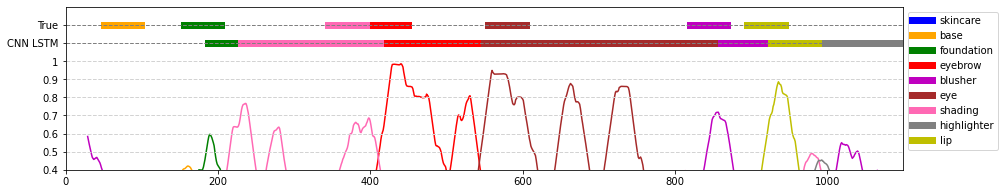

109


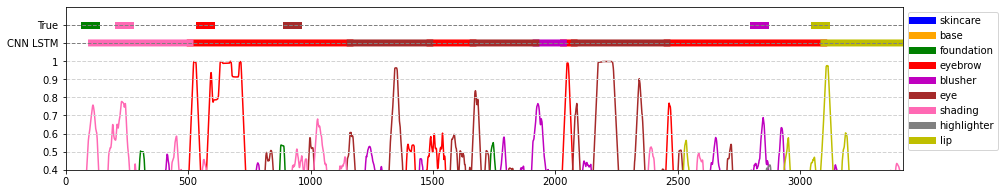

110


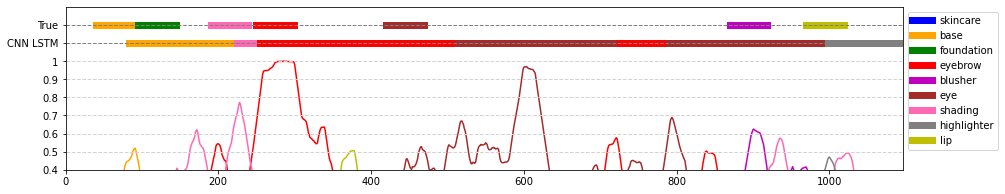

111


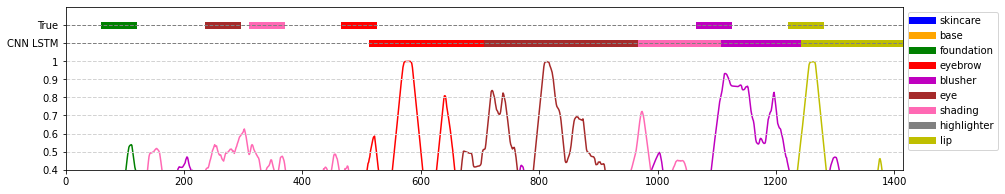

112


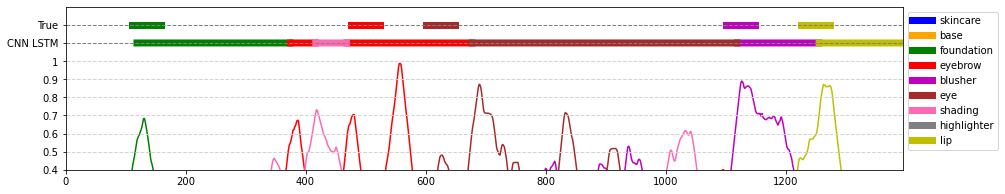

113


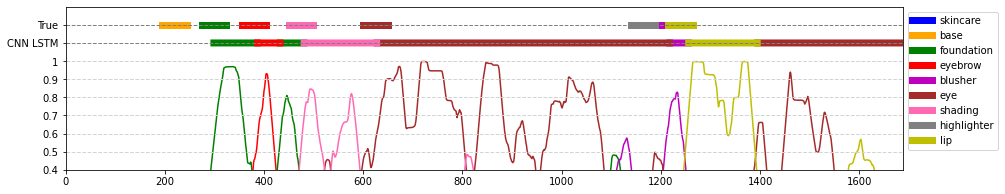

114


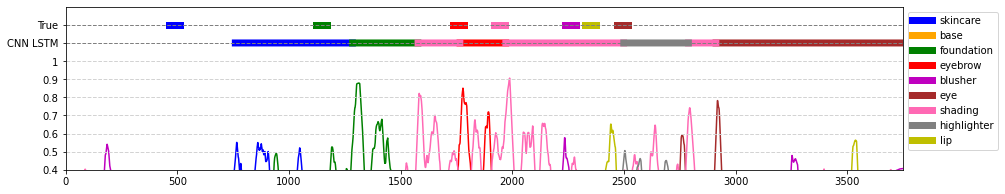

115


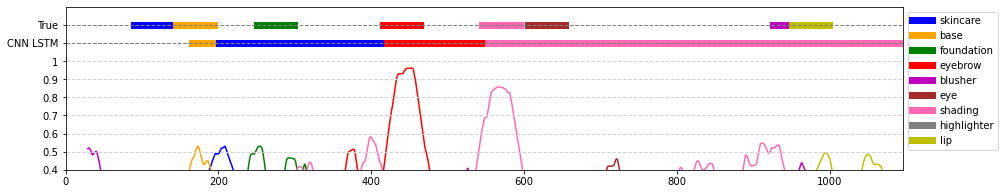

116


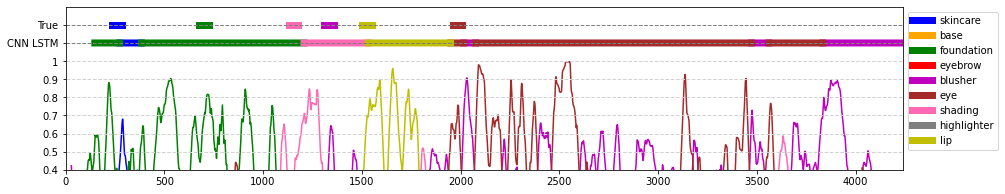

117


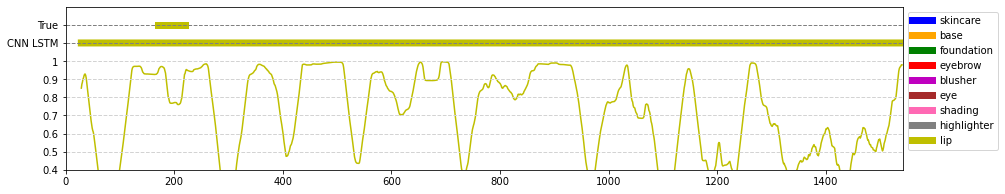

118


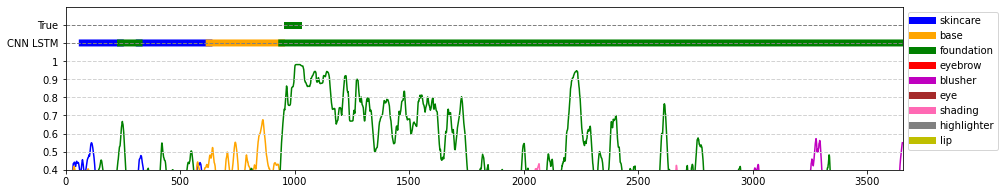

119


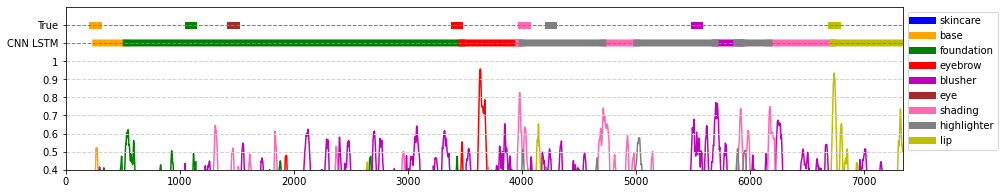

120


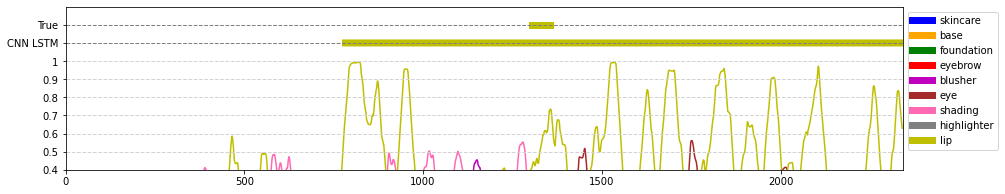

121


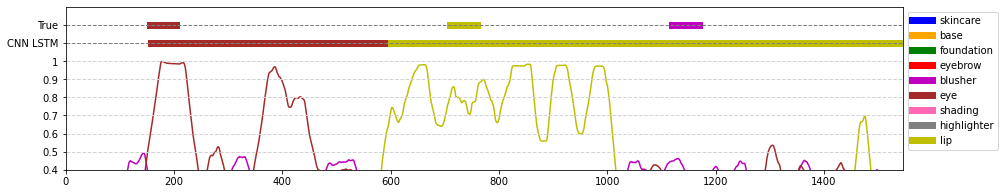

122


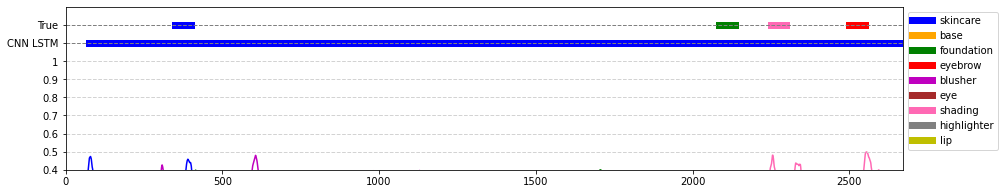

123


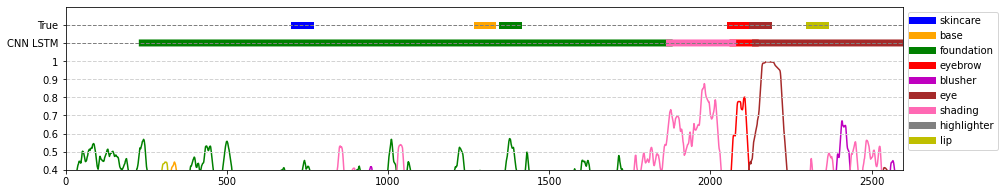

124


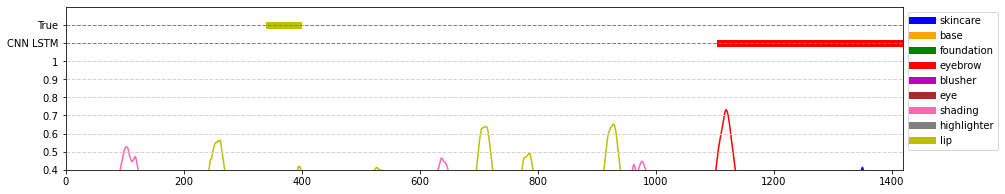

125


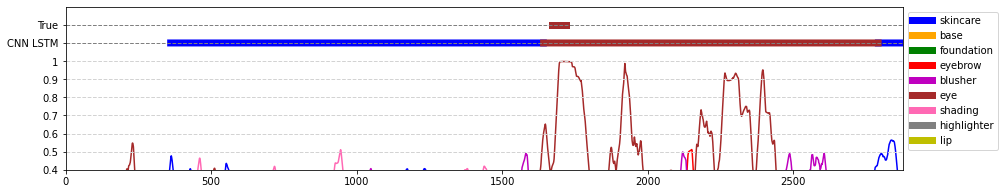

126


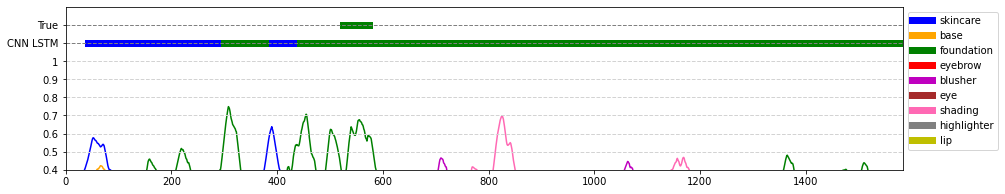

127


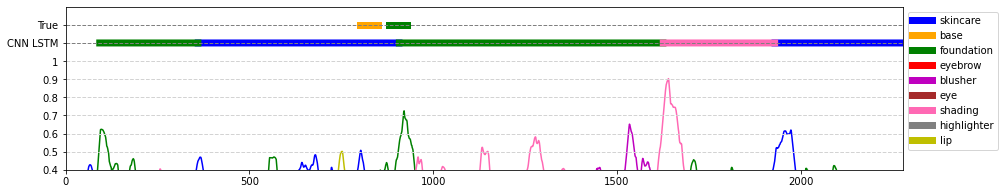

128
129


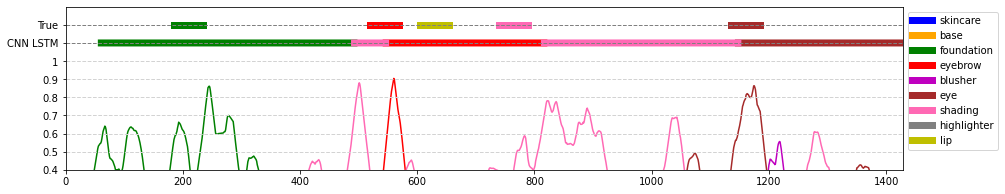

130


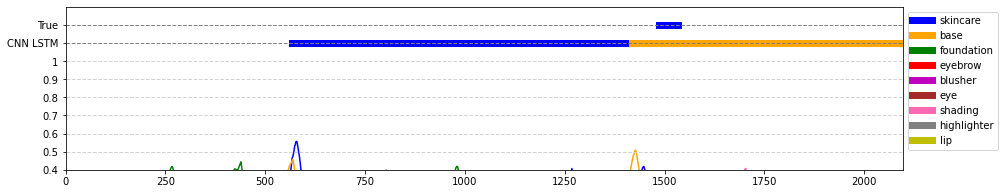

131


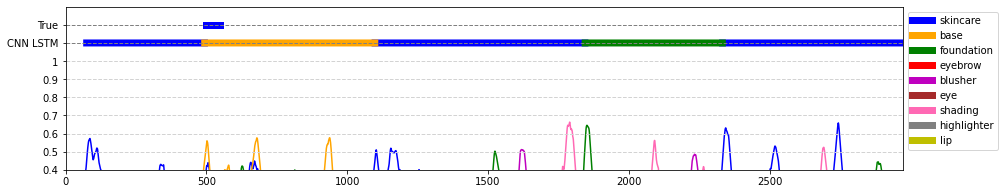

132


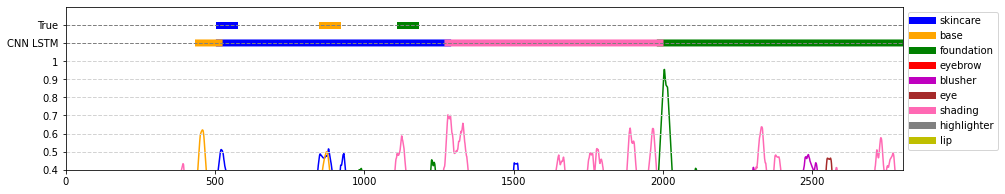

133


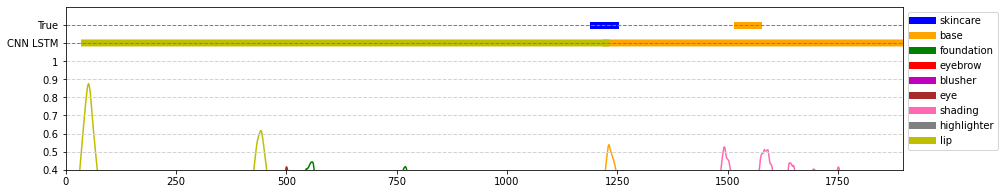

134


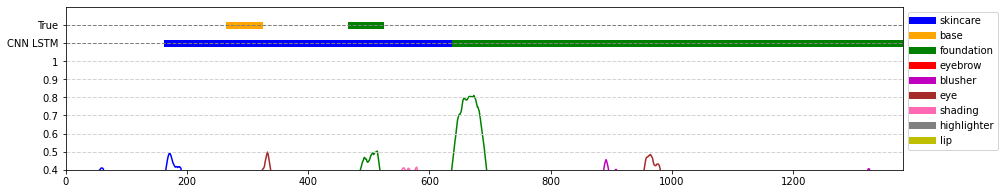

135


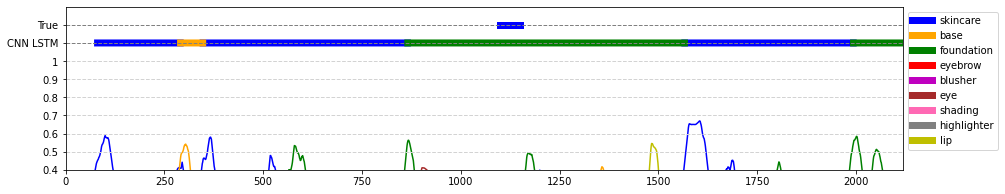

136


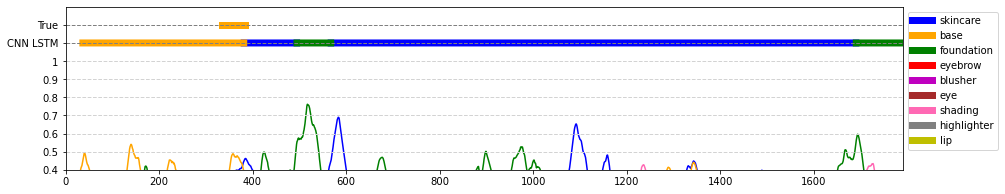

137


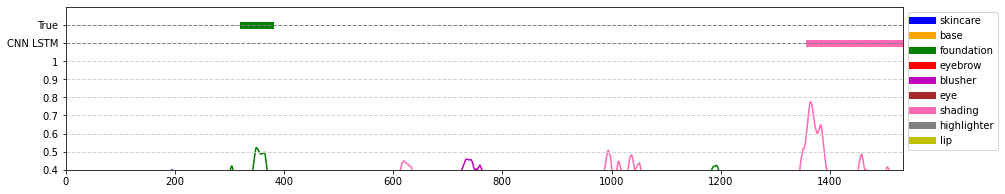

138
139


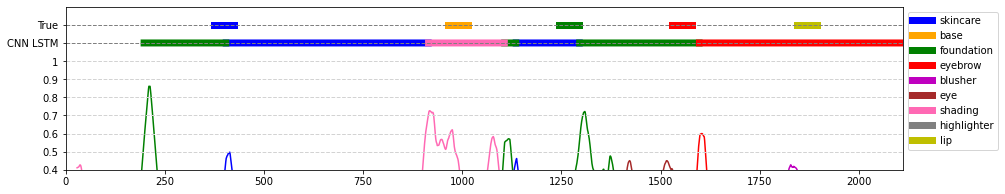

140


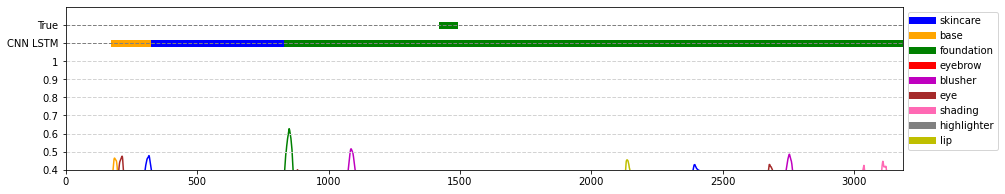

141


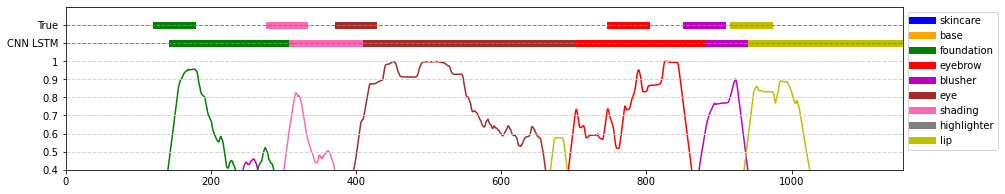

142


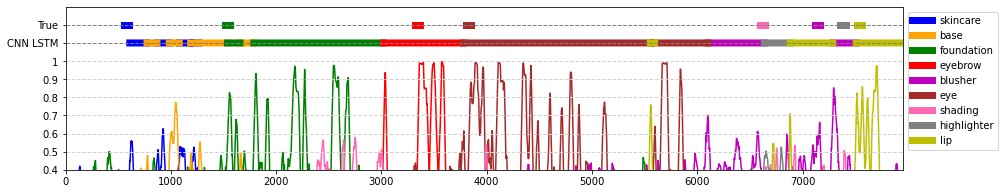

143


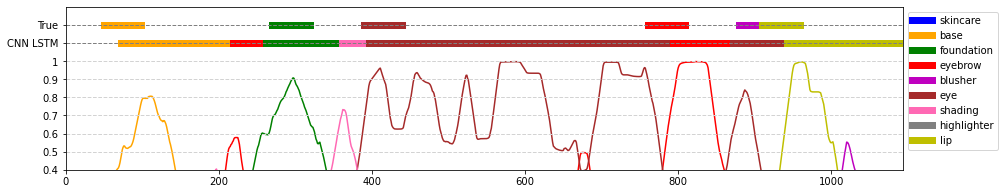

144


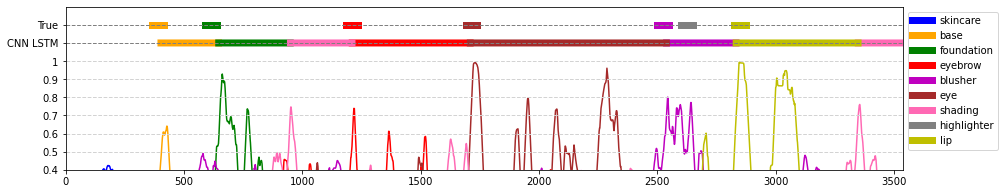

145


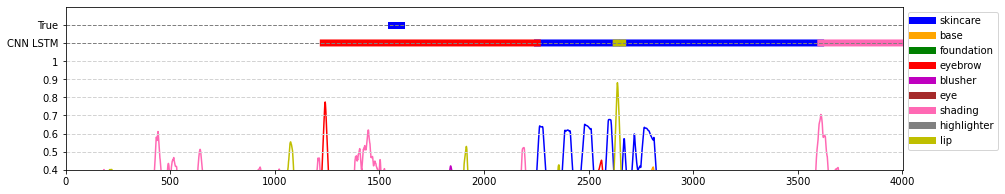

146


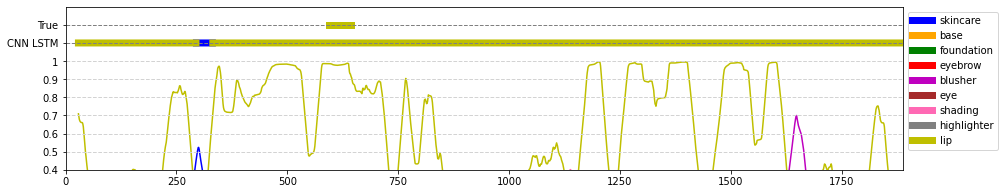

147


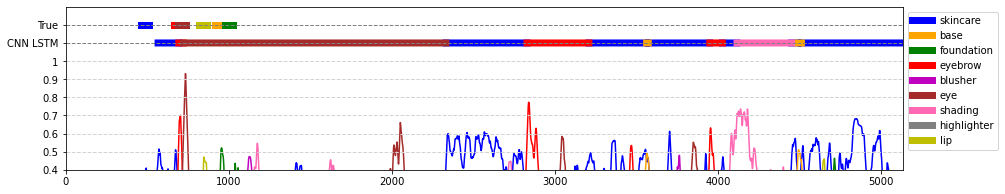

148


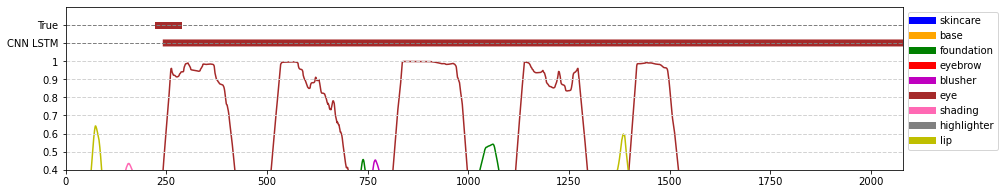

149


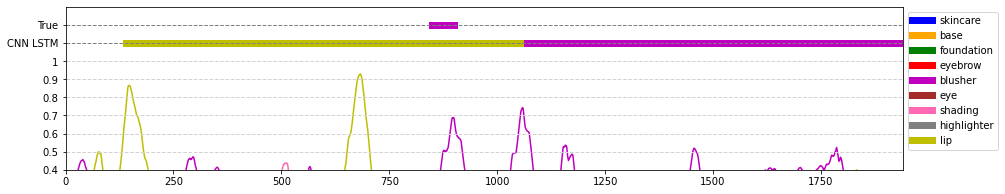

150


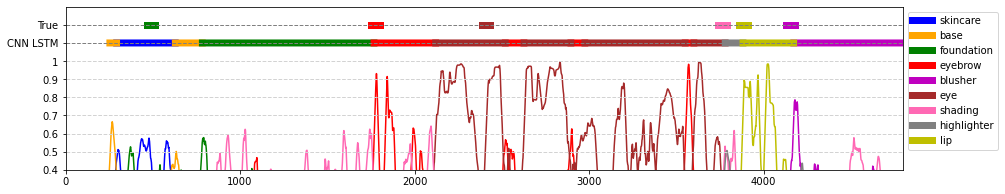

151


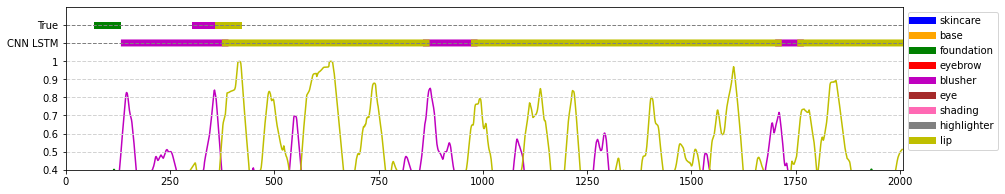

152


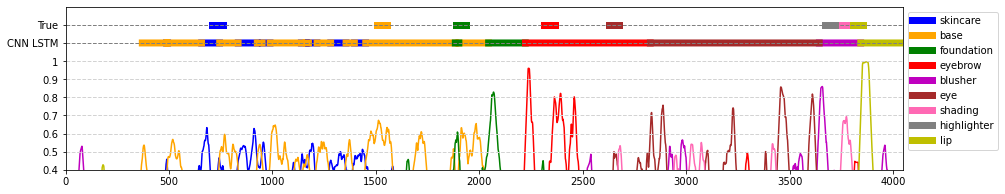

153


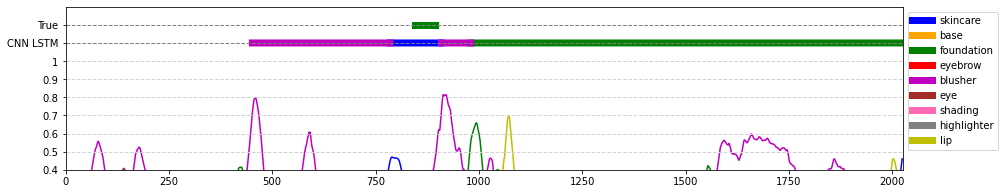

154


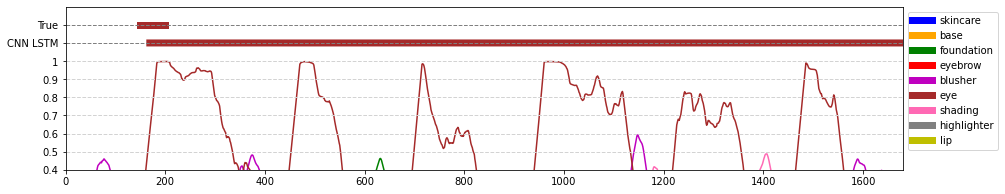

155


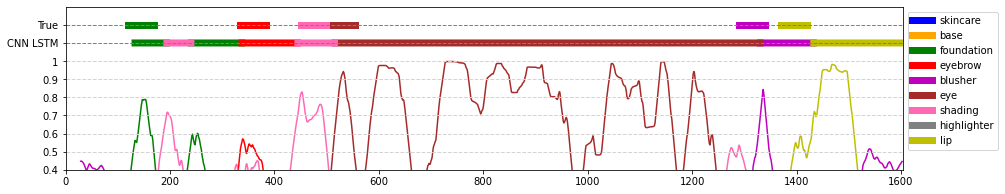

156


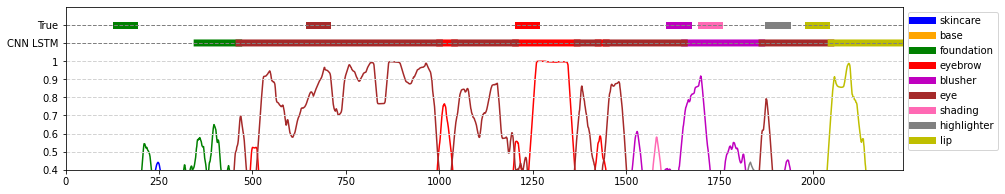

157


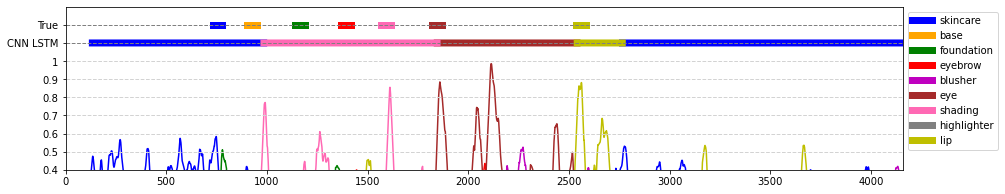

158


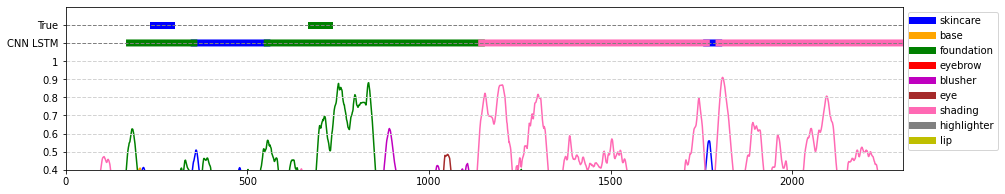

159


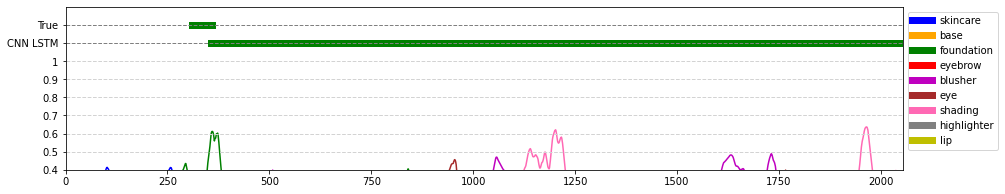

160


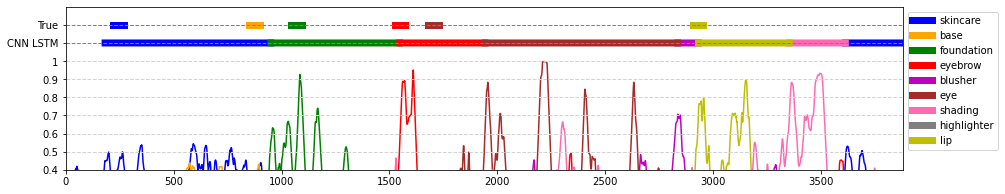

161


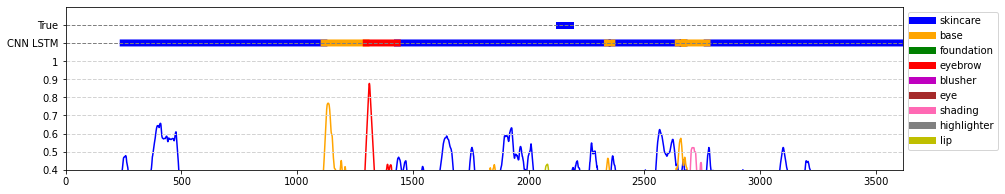

162


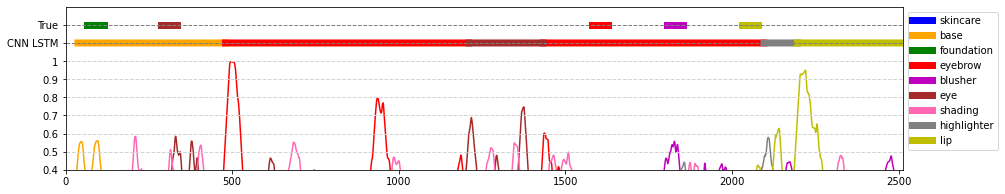

163


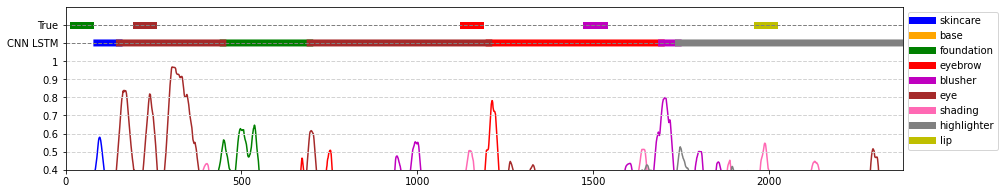

164


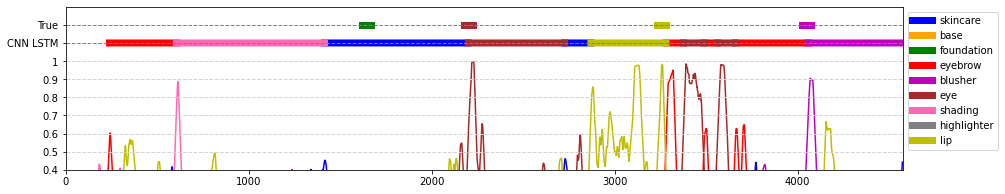

165


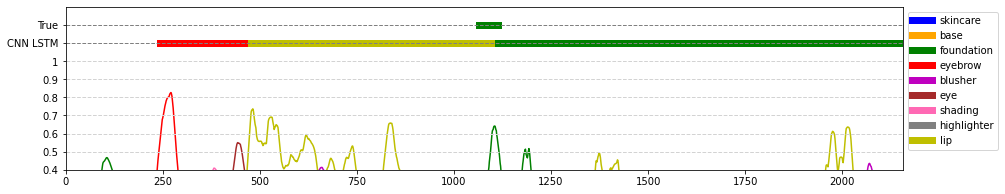

166


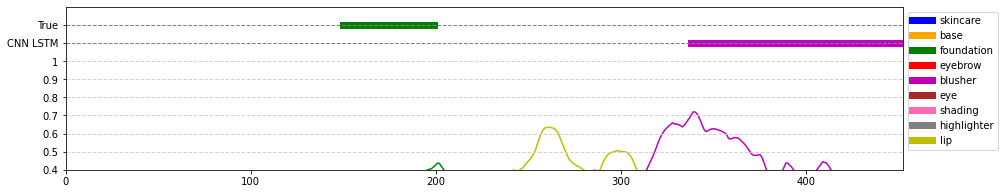

167


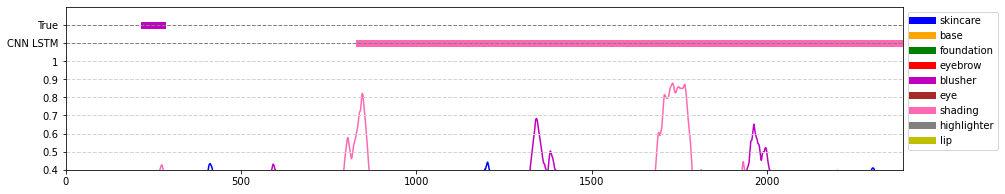

168


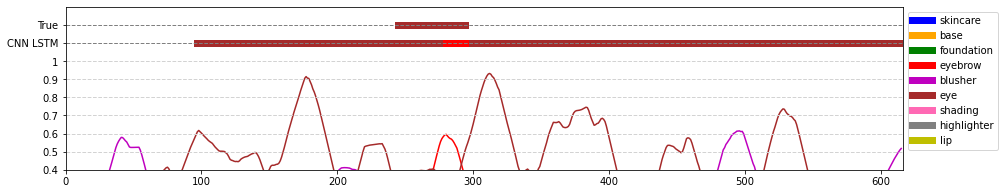

169


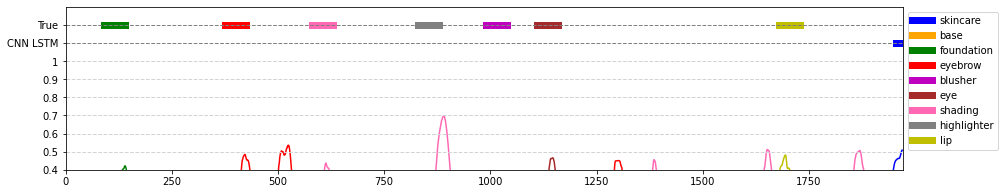

170


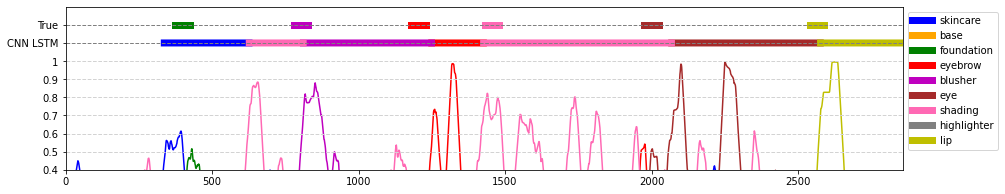

171


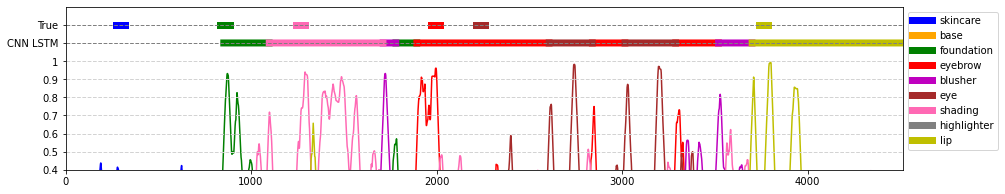

172


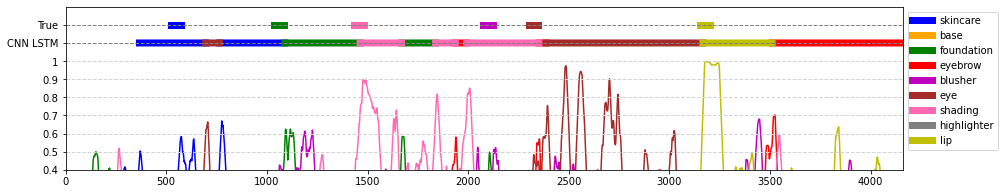

173


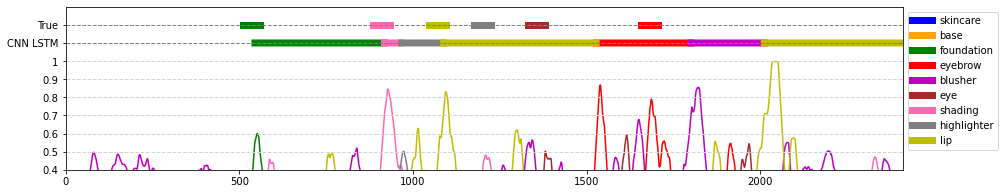

174


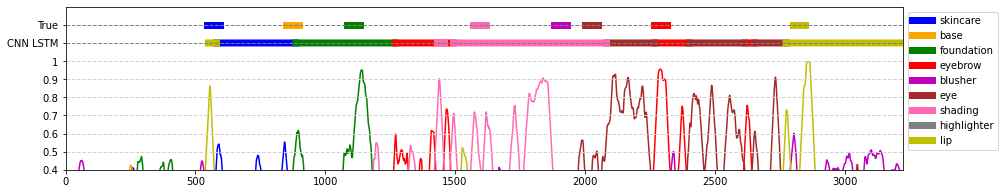

175


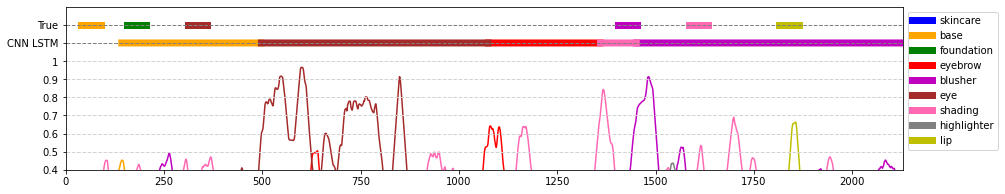

176


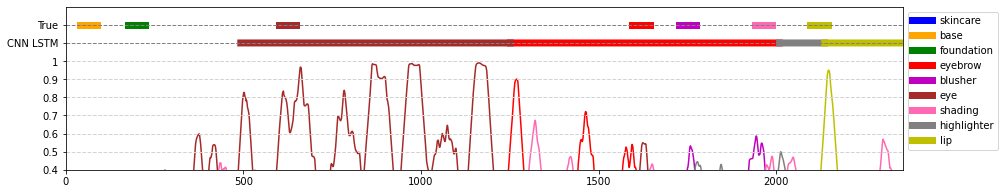

177


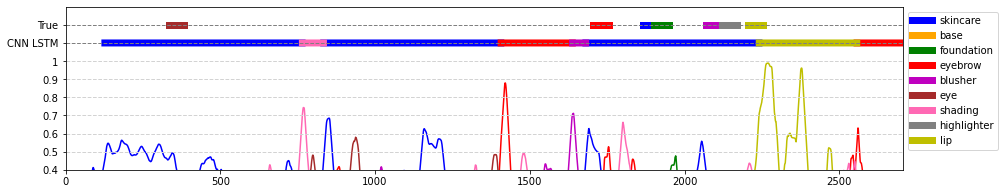

178


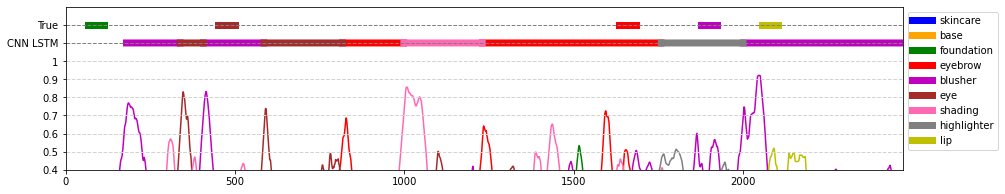

179


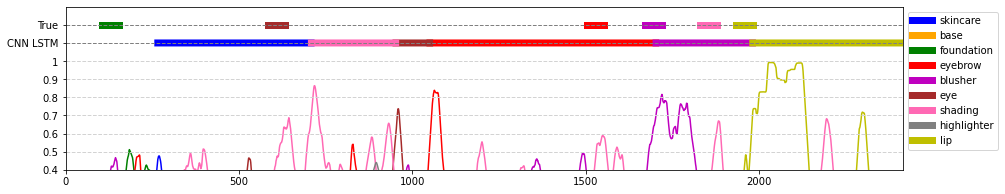

180


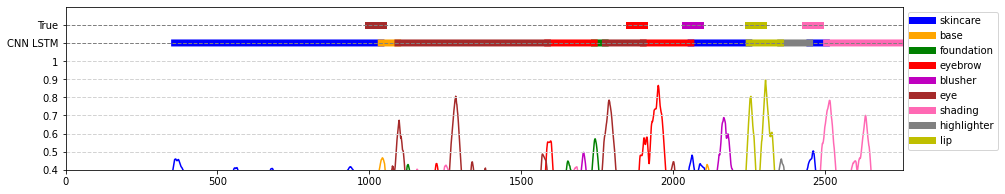

181


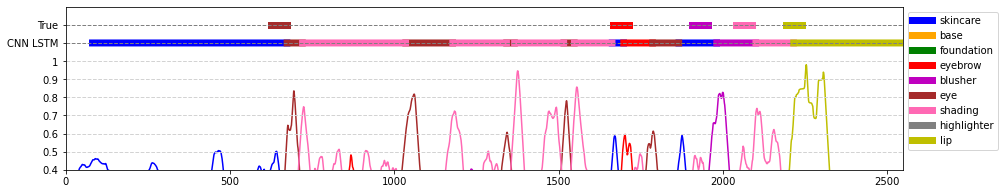

182


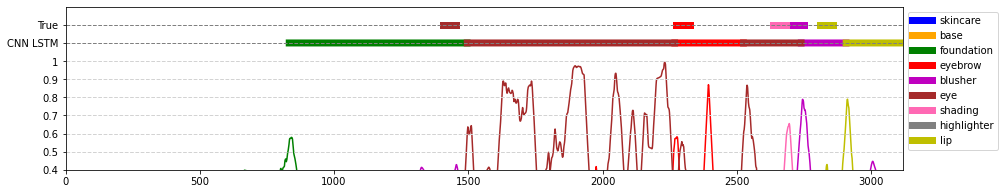

183


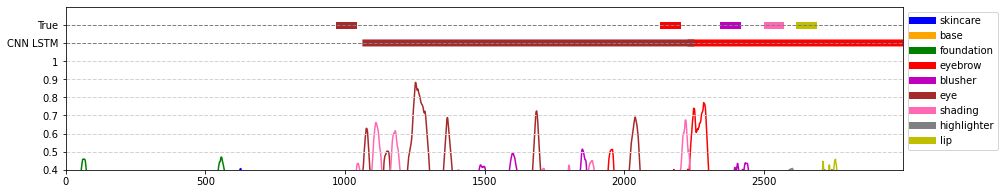

184


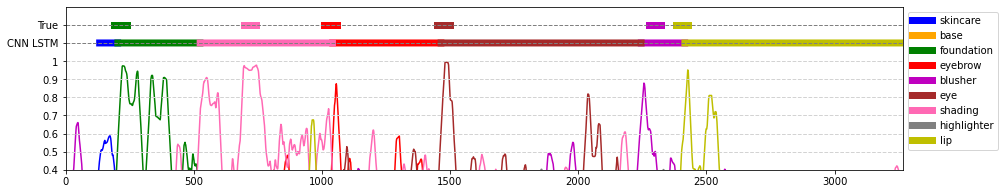

185


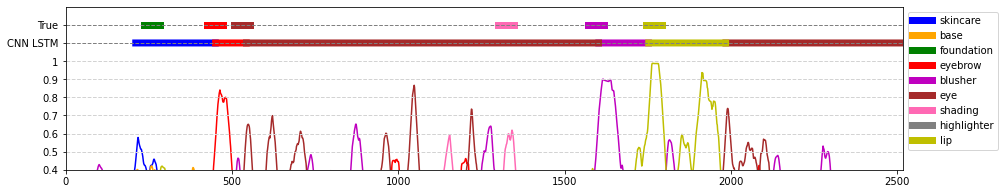

186


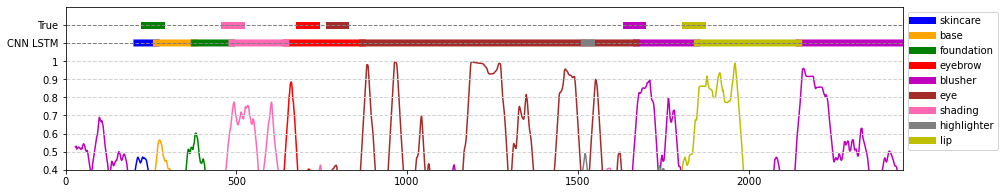

187


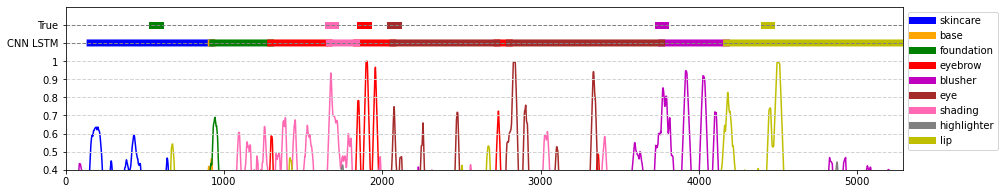

188


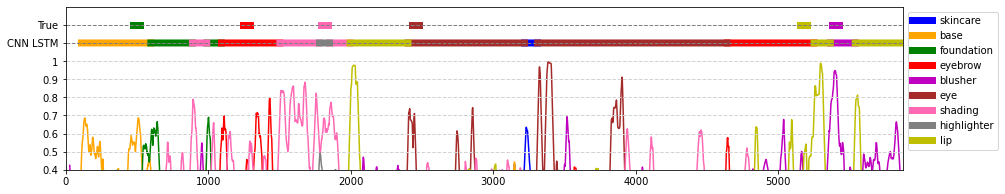

189


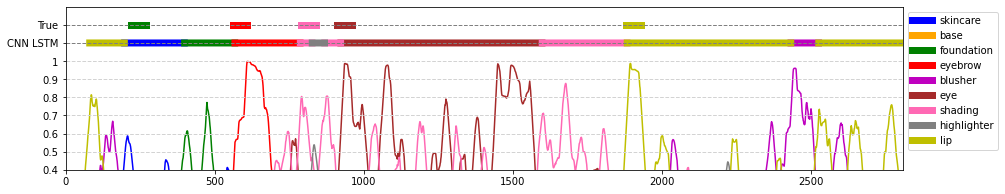

190


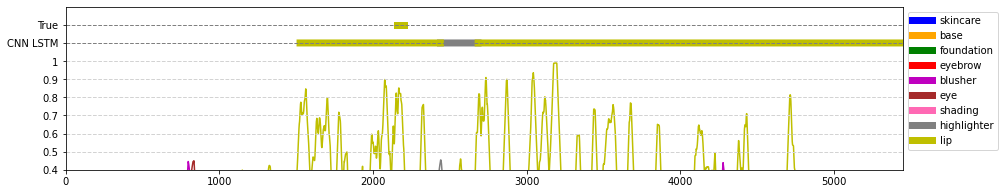

191


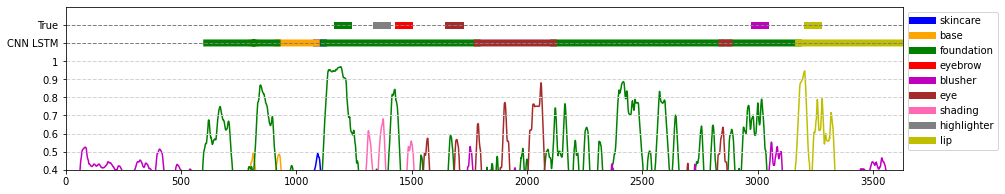

192


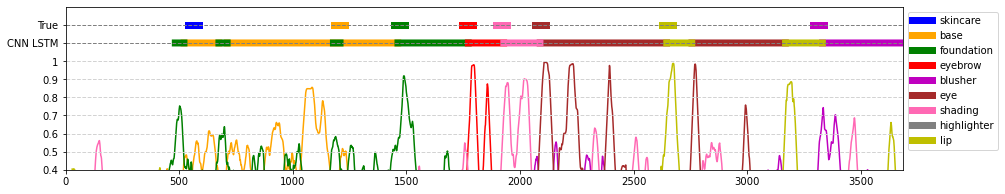

193


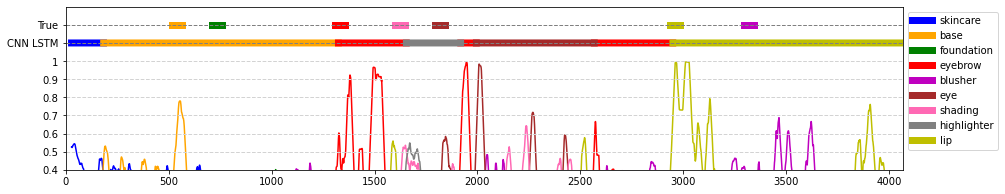

194


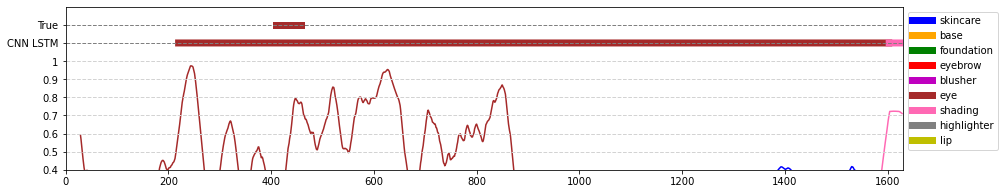

In [4]:
c_list = ['b','orange','g','r','m','brown','hotpink','grey','y']
unique_video = 0
mov = 30
thres_list = [0.45,0.45,0.55,0.55,0.7,0.6,0.7,0.45,0.7]
for k in [0,50,100,150]:
    Validation=[]
    for i in range(0+k,50+k):
        if(i==195):
            break
        Test=TestLabel[i]
        mark=max(Test.starttime)/1000*5
        zero_data = np.zeros(shape=(int(mark)+1,len(ActivityName)))
        Val_temp=pd.DataFrame(zero_data,columns=[2,  3,  4,  5,  6,  7,  9,  1,  8])

        for j in range(0,len(Test)):
            #print (j)
            STidx=Test[j:j+1].starttime.values/1000*5
            if Test[j:j+1].makeuppart_id.values == 10:
                continue
            Val_temp.loc[int(STidx),Test[j:j+1].makeuppart_id]=1
        Val_temp.columns=ActivityName
        Val_temp=Val_temp[ActivityReName]
        Validation.append(Val_temp)

    timestep=5
    x_test=[]
    for i in range(0+k,50+k):
        if(i == 195):
            break
        temp=TestVideo_set[i]
        x_temp=[]
        for j in range(0,len(temp)-timestep):
            x_temp.append(temp[j:j+timestep])
        x_temp=np.asarray(x_temp)
        x_test.append(x_temp)

    LoadModel=load_model('5FPS_5TS_CNN_LSTM_Model_9C_v2.h5')
    result1=[]
    for i in range(0,len(x_test)):
        result_temp1=LoadModel.predict(x_test[i])
        result_temp1=pd.DataFrame(result_temp1, columns=ActivityName)
        result_temp1=result_temp1[ActivityReName]
        result1.append(result_temp1)
    for vid_num in range(0,len(Validation)):
        print(unique_video)
        try:
            df = pd.DataFrame(result1[vid_num])
            df = df.rolling(mov).mean().dropna()
            df_2 = df.copy(deep = True)
            for th in range(len(thres_list)):
                df.iloc[:,th] = df.iloc[:,th].apply(lambda x: x>=thres_list[th]).replace([True, False],[1,0])
            max_val = df.index.max()
            idx_list = df[df.sum(axis = 1) == 1].index
            df = df[df.sum(axis = 1) == 1].reset_index()
            idx_tmp = [i for i in range(idx_list[0],idx_list[-1]+1)]
            df_tmp = pd.DataFrame(idx_tmp)
            df_tmp.columns = ['index']
            df_tmp.loc[len(df_tmp),'index'] = max_val
            df = pd.merge(df_tmp,df,how = 'left').fillna(0)
            idx_list = list(df[df.iloc[:,1:].sum(axis = 1) == 1].index);idx_list.append(max_val)

            for i in range(len(idx_list)-1):
                df.iloc[idx_list[i]:idx_list[i+1],1:] = df.iloc[idx_list[i]:idx_list[i+1],1:].cumsum()

            df_vid = Validation[vid_num].apply(lambda x: x>=0.5).replace([True, False],[1,0]).reset_index()

            df_vid = df_vid.replace([0,1],[np.nan,1.2])
            df = df.replace([0,1],[np.nan,1.1])
            
            fig,ax = plt.subplots(figsize=(15,3))
            m = 0
            for part in ActivityReName:
                try:
                    l_range = list(range(int(df_vid[df_vid[part] == 1.2]['index'].values[0]-25),int(df_vid[df_vid[part] == 1.2]['index'].values[0]+25)))
                except:
                    l_range = [np.nan]
                plt.plot(l_range,[1.2 for i in range(len(l_range))],linewidth = 7, c = c_list[m])
                m = m+1
            m = 0
            for part in ActivityReName:
                plt.plot(df['index'],df[part],linewidth = 7, c = c_list[m])
                m = m+1
            m = 0    
            for part in ActivityReName:
                plt.plot(df_2.index,df_2[part],linewidth = 1.5, c = c_list[m])
                m = m+1
            plt.xlim(0,len(result1[vid_num]))
            plt.ylim(0.4,1.3)
            plt.axhline(1.1, c = 'grey',linestyle = '--', linewidth = 1)
            plt.axhline(1.2, c = 'grey',linestyle = '--', linewidth = 1)

            plt.axhline(0.5, c = 'lightgrey',linestyle = '--', linewidth = 1)
            plt.axhline(0.6, c = 'lightgrey',linestyle = '--', linewidth = 1)
            plt.axhline(0.7, c = 'lightgrey',linestyle = '--', linewidth = 1)
            plt.axhline(0.8, c = 'lightgrey',linestyle = '--', linewidth = 1)
            plt.axhline(0.9, c = 'lightgrey',linestyle = '--', linewidth = 1)
            plt.axhline(1, c = 'lightgrey',linestyle = '--', linewidth = 1)

            plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2],[0.4,0.5,0.6,0.7,0.8,0.9,1,'CNN LSTM','True'])
            plt.legend(ActivityReName,bbox_to_anchor=(1, 1), loc='upper left')
            plt.show()
            unique_video = unique_video+1
        except:
            unique_video = unique_video+1
            continue
    del result_temp1, Validation, x_test, result1